## Amino acid composition weighted by copy number
#### Last updated 2023-02-25
This notebook computes a series of statistical analyses using protein abundance (copy number) information from a range of different sources.

#### Changelog
We updated the arbidoposis data to V2 to reflect a more conservative way. Of assigning the TAIR ORF ID to the UniProt ID. Specifically, in V2 IF a reviewed UniProt ID is associated with the TAIR ORF ID this is ALWAYS used, otherwise ALL the un-reviewed uniprotIDs are used.

### Relevant publications

#### Human proteome
Hein, M. Y., Hubner, N. C., Poser, I., Cox, J., Nagaraj, N., Toyoda, Y., Gak, I. A., Weisswange, I., Mansfeld, J., Buchholz, F., Hyman, A. A., & Mann, M. (2015). A human interactome in three quantitative dimensions organized by stoichiometries and abundances. Cell, 163(3), 712–723.

#### A. thaliana proteome
Bassal, M., Abukhalaf, M., Majovsky, P., Thieme, D., Herr, T., Ayash, M., Tabassum, N., Al Shweiki, M. R., Proksch, C., Hmedat, A., Ziegler, J., Lee, J., Neumann, S., & Hoehenwarter, W. (2020). Reshaping of the Arabidopsis thaliana Proteome Landscape and Co-regulation of Proteins in Development and Immunity. Molecular Plant, 13(12), 1709–1732.

#### D. melanogaster proteome
Bonnet, J., Lindeboom, R. G. H., Pokrovsky, D., Stricker, G., Çelik, M. H., Rupp, R. A. W., Gagneur, J., Vermeulen, M., Imhof, A., & Müller, J. (2019). Quantification of Proteins and Histone Marks in Drosophila Embryos Reveals Stoichiometric Relationships Impacting Chromatin Regulation. Developmental Cell, 51(5), 632–644.e6.

#### E. coli proteomes
Wiśniewski, J. R., & Rakus, D. (2014). Quantitative analysis of the Escherichia coli proteome. Data in Brief, 1, 7–11.

Ishihama, Y., Schmidt, T., Rappsilber, J., Mann, M., Hartl, F. U., Kerner, M. J., & Frishman, D. (2008). Protein abundance profiling of the Escherichia coli cytosol. BMC Genomics, 9, 102.

#### S. pombe proteome
Carpy, A., Krug, K., Graf, S., Koch, A., Popic, S., Hauf, S., & Macek, B. (2014). Absolute proteome and phosphoproteome dynamics during the cell cycle of Schizosaccharomyces pombe (Fission Yeast). Molecular & Cellular Proteomics: MCP, 13(8), 1925–1936.

#### S. cerevisiae

Ghaemmaghami, S., Huh, W.-K., Bower, K., Howson, R. W., Belle, A., Dephoure, N., O’Shea, E. K., & Weissman, J. S. (2003). Global analysis of protein expression in yeast. Nature, 425(6959), 737–741.

Lawless, C., Holman, S. W., Brownridge, P., Lanthaler, K., Harman, V. M., Watkins, R., Hammond, D. E., Miller, R. L., Sims, P. F. G., Grant, C. M., Eyers, C. E., Beynon, R. J., & Hubbard, S. J. (2016). Direct and Absolute Quantification of over 1800 Yeast Proteins via Selected Reaction Monitoring. Molecular & Cellular Proteomics: MCP, 15(4), 1309–1322.

In [10]:
### PLOTTING SETTINGS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
import scipy
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir', 
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [11]:
import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_protein_attributes, si_domains
from sparrow import Protein


In [12]:
# defines the percentile step to classify 
step=5

def get_percentile(target, pvals, step):
    """
    Local function that takes in the a copy number
    (target) and the pvals list and returns the pvalue 
    associated with the target.
    
    Parameters
    ---------------
    target : numerical
        A number that represents the copy number of some 
        protein of interest
        
    pvals : list
        The pre-computed list of pvalues; should be 100
        elements where index = copy number at the associated
        index position.

    Returns
    ----------------
    
    """
    for i in range(0,100+step,step):
        if pvals[i] > target:
            return i


In [5]:

#             

datasets = {'arabidopsis':[],
            'e_coli_wisniewski': [],
            'e_coli_ishihama': [],
            'pombe':[],
            'yeast_lawless':[],
            'yeast_ghaemmaghami':[],
            'human':[],
            'xenopus':[]}
            

datasets['arabidopsis'].append('../shprd_data/arabidopsis/arabidopsis_clean.fasta')
datasets['arabidopsis'].append('../shprd_data/arabidopsis/shprd_arabidopsis_copynumber_bassal_reviewed_abundance_leaf_time_v2.tsv')
datasets['arabidopsis'].append('../shprd_data/arabidopsis/shprd_domains_idrs_arabidopsis.tsv')

datasets['e_coli_ishihama'].append('../shprd_data/e_coli/ecoli_clean.fasta')
datasets['e_coli_ishihama'].append('../shprd_data/e_coli/shprd_ecoli_copynumber_ishihama.tsv')
datasets['e_coli_ishihama'].append('../shprd_data/e_coli/shprd_domains_idrs_ecoli.tsv')

datasets['e_coli_wisniewski'].append('../shprd_data/e_coli/ecoli_clean.fasta')
datasets['e_coli_wisniewski'].append('../shprd_data/e_coli/shprd_ecoli_copynumber_wisniewski.tsv')
datasets['e_coli_wisniewski'].append('../shprd_data/e_coli/shprd_domains_idrs_ecoli.tsv')

datasets['pombe'].append('../shprd_data/pombe/pombe_clean.fasta')
datasets['pombe'].append('../shprd_data/pombe/shprd_pombe_copynumber.tsv')
datasets['pombe'].append('../shprd_data/pombe/shprd_domains_idrs_pombe.tsv')

datasets['yeast_lawless'].append('../shprd_data/yeast/s_cerevisiae_clean.fasta')
datasets['yeast_lawless'].append('../shprd_data/yeast/shprd_yeast_copynumber_lawless.tsv')
datasets['yeast_lawless'].append('../shprd_data/yeast/shprd_domains_idrs_s_cerevisiae.tsv')

datasets['yeast_ghaemmaghami'].append('../shprd_data/yeast/s_cerevisiae_clean.fasta')
datasets['yeast_ghaemmaghami'].append('../shprd_data/yeast/shprd_yeast_copynumber_ghaemmaghami.tsv')
datasets['yeast_ghaemmaghami'].append('../shprd_data/yeast/shprd_domains_idrs_s_cerevisiae.tsv')

datasets['human'].append('../shprd_data/human_proteome_validated.fasta')
datasets['human'].append('../shprd_data/shprd_protein_attributes_concentrations.tsv')
datasets['human'].append('../shprd_data/shprd_domains_idrs_metapredict_v2.tsv')

datasets['xenopus'].append('../shprd_data/xenopus/xenopus_clean.fasta')
datasets['xenopus'].append('../shprd_data/xenopus/shprd_xenopus_copynumber.tsv')
datasets['xenopus'].append('../shprd_data/xenopus/shprd_domains_idrs_xenopus.tsv')


all_proteomes = {}
for i in datasets:
    print(f'Parsing data for {i}')
    tmp = uniprot.uniprot_fasta_to_proteome(datasets[i][0])
    si_protein_attributes.add_protein_attributes_from_file(tmp, datasets[i][1])
    si_domains.add_domains_from_file(tmp, datasets[i][2])
    
    # remove proteins missing the copy_number annotation, and for those where 
    # present cast into an Int
    remove = []
    for protein in tmp:
        if 'copy_number' not in protein.attributes:
            remove.append(protein.unique_ID)
        else:
            
            # note this just cast the string to a float and then rounds to nearest integer...
            protein.add_attribute('copy_number', int(np.rint(float(protein.attribute('copy_number')))), safe=False)
    tmp.remove_proteins(remove)
    
    # associate the Proteome with the dictionary
    all_proteomes[i] = tmp
    
    


Parsing data for arabidopsis
Parsing data for e_coli_wisniewski
Parsing data for e_coli_ishihama
Parsing data for pombe
Parsing data for yeast_lawless
Parsing data for yeast_ghaemmaghami
Parsing data for human
Parsing data for xenopus


In [6]:
for i in all_proteomes:
    for p in all_proteomes[i]:
        p.add_attribute('fraction_disordered', np.round(np.sum([len(d) for d in p.domains])/len(p),2))
        p.add_attribute('disordered_count', np.round(np.sum([len(d) for d in p.domains]),2))
        

In [7]:
all_pvals = {}
for organism in all_proteomes:
    
    all_copy_numbers = []
    for p in all_proteomes[organism]:
        all_copy_numbers.append(p.attribute('copy_number'))
        
    pvals = []
    for i in range(0,101):
        pvals.append(int(np.percentile(all_copy_numbers,i)))
    all_pvals[organism] = pvals
        

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


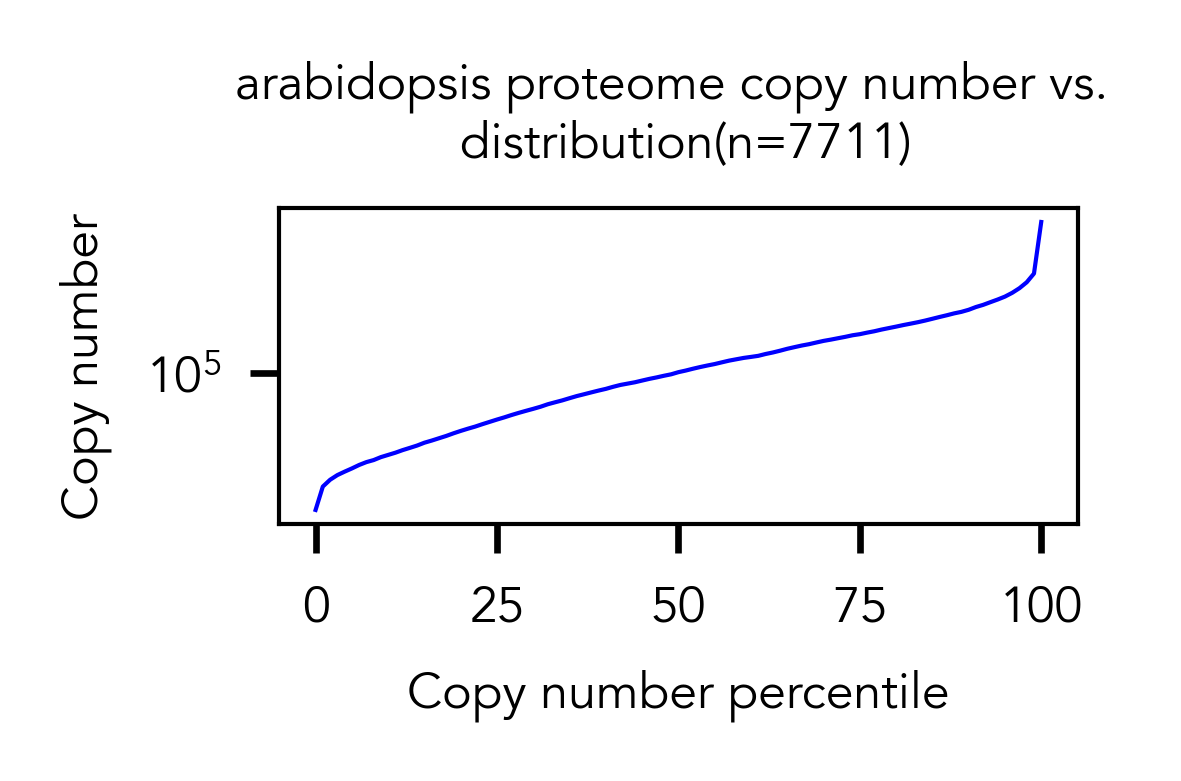

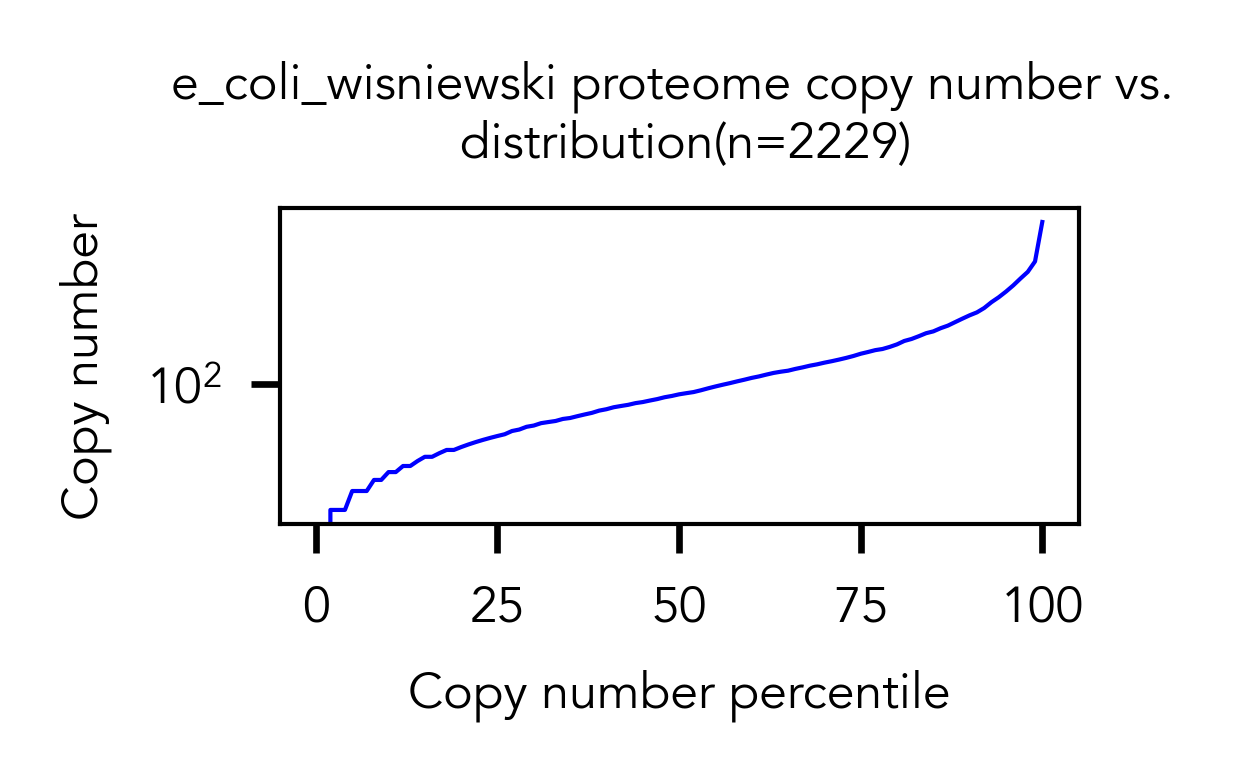

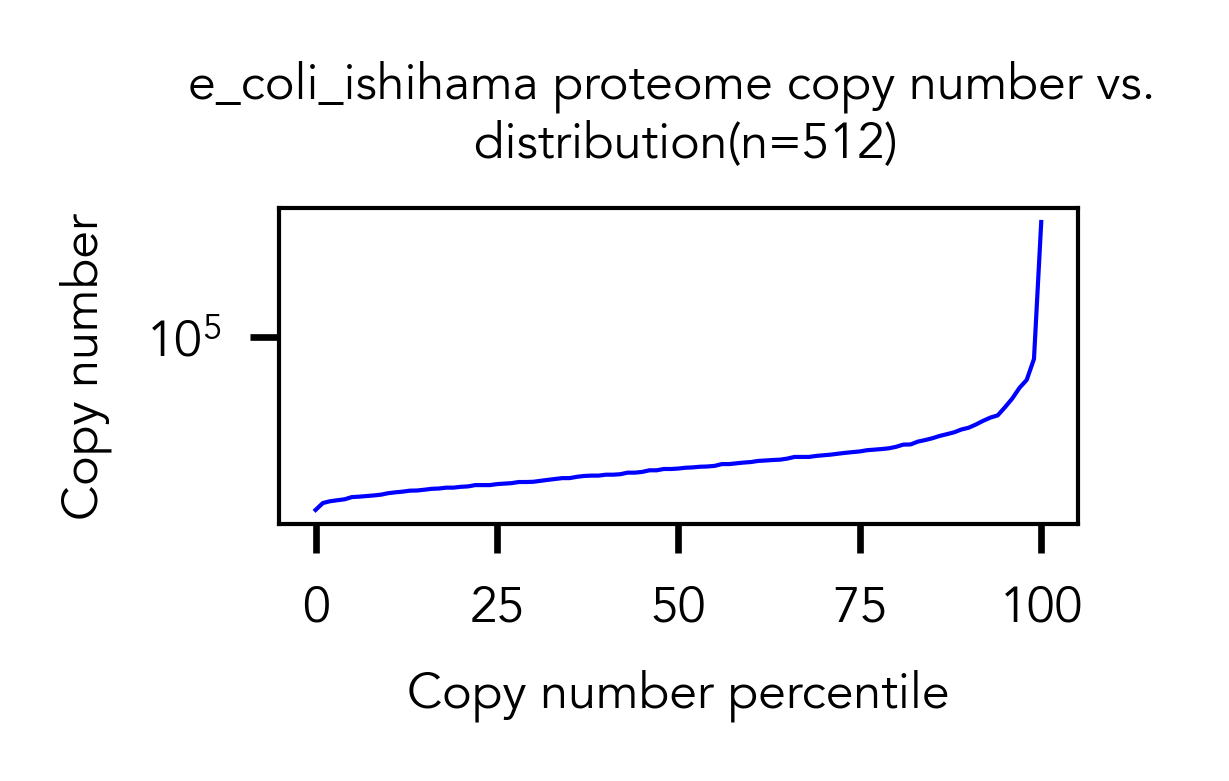

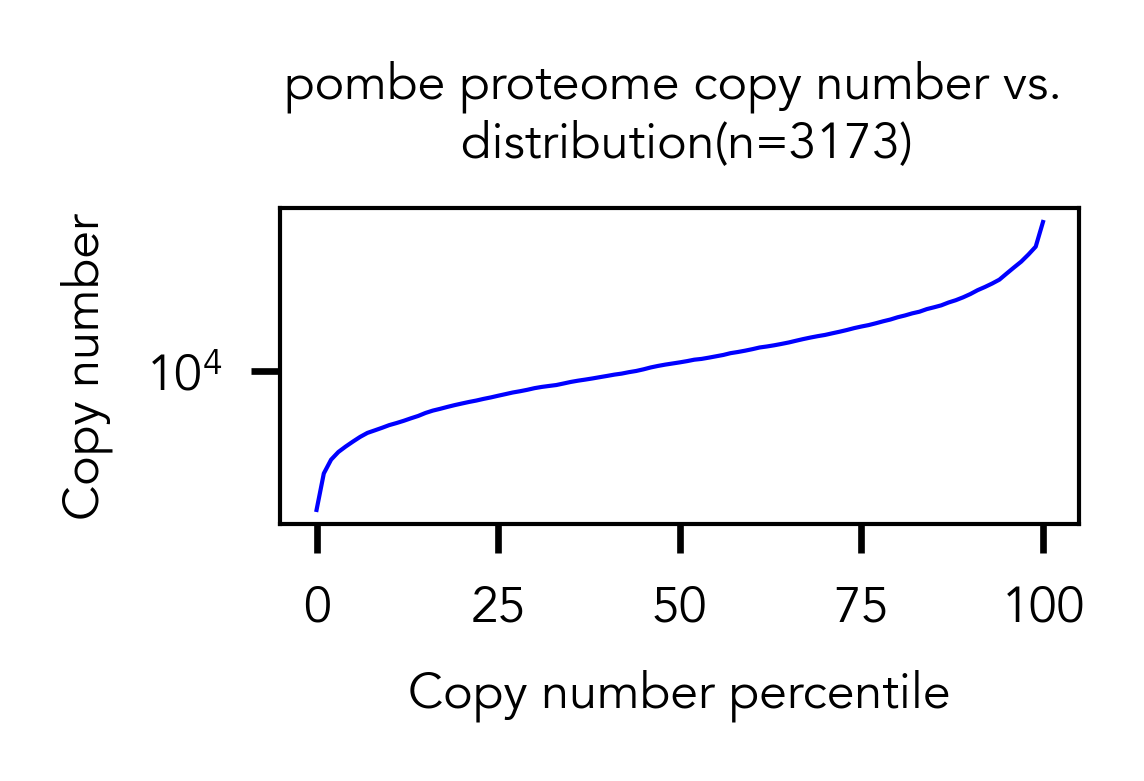

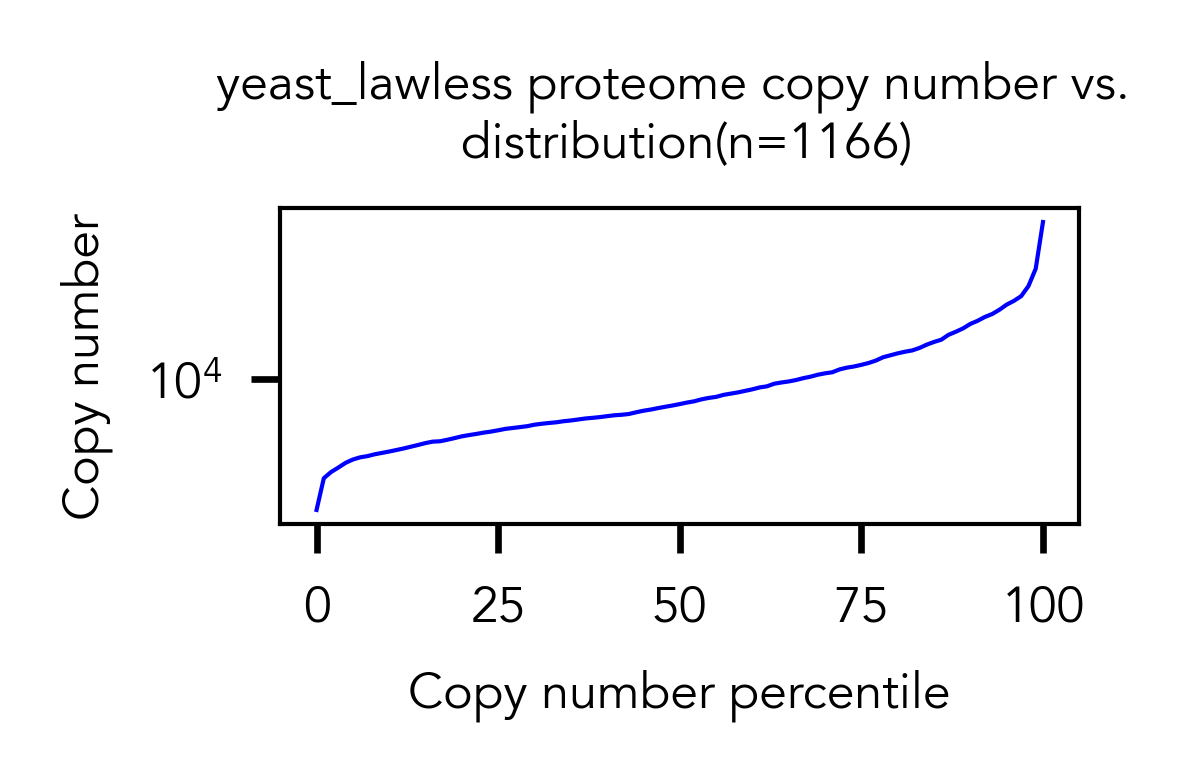

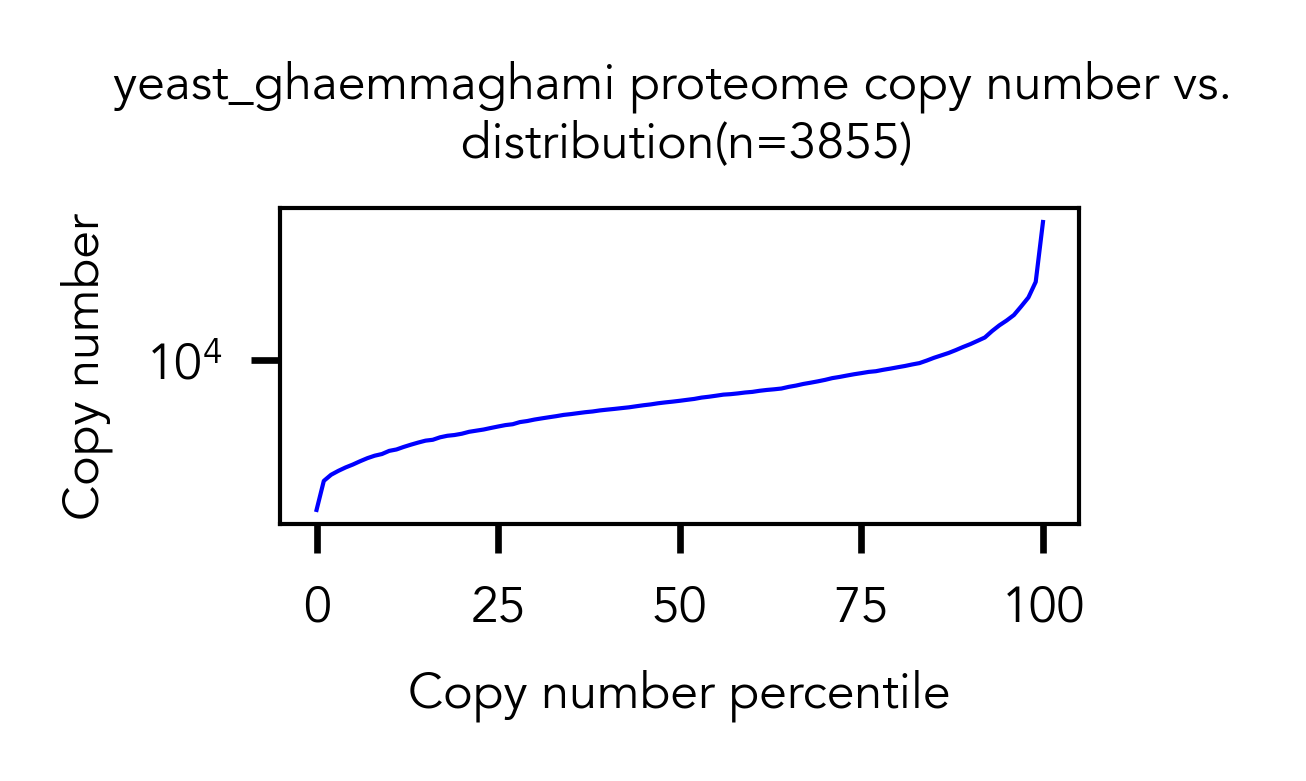

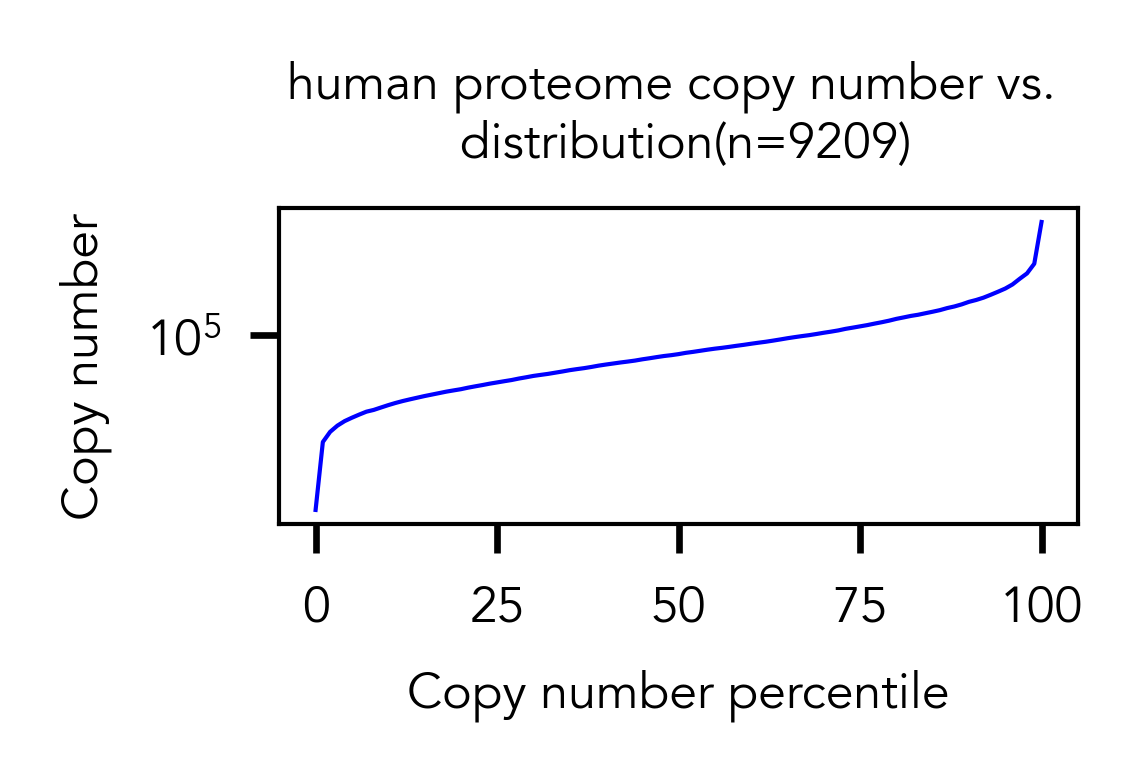

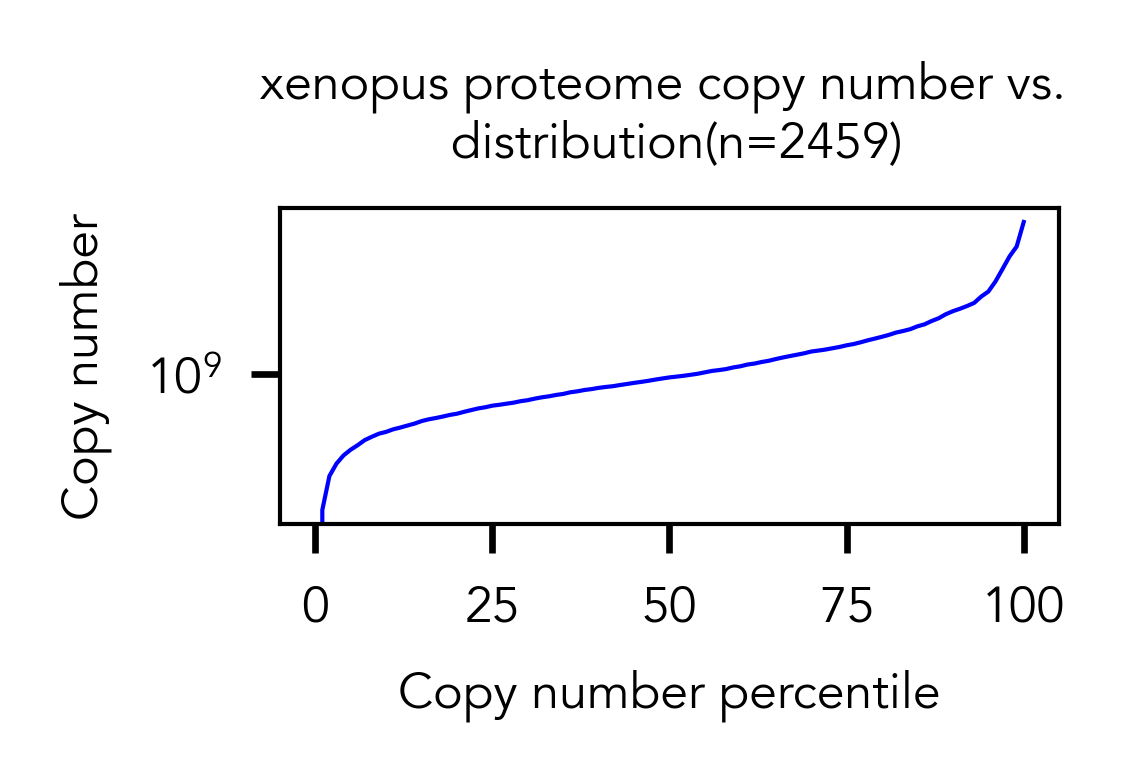

In [8]:
for organism in all_proteomes:
    figure(None, (2,1.4), dpi=300)
    plt.plot(np.arange(0,101), all_pvals[organism], color='b',linewidth=0.5)
    plt.yscale('log')
    plt.xticks([0,25,50,75,100],fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel('Copy number percentile',fontsize=6)
    plt.ylabel('Copy number',fontsize=6)
    plt.title(f'{organism} proteome copy number vs. \n distribution(n={len(all_proteomes[organism])})',fontsize=6)
    plt.tight_layout()
    plt.savefig(f'../FIGURES/copy_number/overall_count_{organism}.pdf')

#### Compute copy number percentile for every protein
Allocate each protein a percentile between 0 and 100

In [13]:
for organism in all_proteomes:
    proteome = all_proteomes[organism]
        
    for protein in proteome:    
    
        protein.add_attribute('copy_number_percentile', get_percentile(protein.attribute('copy_number'),  all_pvals[organism], step))
        
        

#### Compute sequence properties at each percentile

In [14]:
all_parameters = {}
for organism in all_proteomes:
    
    proteome = all_proteomes[organism]

    cnp_to_fraction_disorder = {}
    cnp_to_disorder_count = {}
    cnp_to_protein = {}
    cnp_to_idr_fcr = {}

    for p in proteome:
        cn_p = p.attribute('copy_number_percentile')


        if cn_p not in cnp_to_fraction_disorder:
            cnp_to_fraction_disorder[cn_p] = []
            cnp_to_disorder_count[cn_p] = []
            cnp_to_protein[cn_p] = []
            cnp_to_idr_fcr[cn_p] = []


        if len(p.domains) > 0:
            
            local_fcr = []
            for d in p.domains:
                if len(d) > 50:
                    ncr = d.sequence.count('K') + d.sequence.count('R') + d.sequence.count('D') + d.sequence.count('E')
                    local_fcr.append(ncr/len(d))
                    
            if len(local_fcr) >0:
                cnp_to_idr_fcr[cn_p].append(min(local_fcr))
            #idr_res = "".join([d.sequence for d in p.domains])
            #cnp_to_idr_fcr[cn_p].append((idr_res.count('K')+idr_res.count('R')+idr_res.count('E')+idr_res.count('D'))/len(idr_res))
        cnp_to_fraction_disorder[cn_p].append(p.attribute('fraction_disordered'))
        cnp_to_disorder_count[cn_p].append(p.attribute('disordered_count'))
        cnp_to_protein[cn_p].append(p)
        
        
    all_parameters[organism] = {}
    
    all_parameters[organism]['cnp_to_fraction_disorder'] = cnp_to_fraction_disorder
    all_parameters[organism]['cnp_to_disorder_count'] = cnp_to_disorder_count
    all_parameters[organism]['cnp_to_idr_fcr'] = cnp_to_idr_fcr
    
    all_parameters[organism]['cnp_to_protein'] = cnp_to_protein




In [15]:

all_mean_parameters = {}

for organism in all_proteomes:
    
    all_mean_parameters[organism] = {}


    mean_disorder_count = []
    mean_disorder_fraction = []
    mean_protein_length = []
    mean_idr_fcr = []



    print(organism)
    percentile_idx = []
    for i in range(step,100+step, step):
        percentile_idx.append(i)


        mean_disorder_count.append(np.mean(all_parameters[organism]['cnp_to_disorder_count'][i]))
        mean_disorder_fraction.append(np.mean(all_parameters[organism]['cnp_to_fraction_disorder'][i]))
        mean_protein_length.append(np.mean([len(k) for k in all_parameters[organism]['cnp_to_protein'][i]]))
        mean_idr_fcr.append(np.mean(all_parameters[organism]['cnp_to_idr_fcr'][i]))

    all_mean_parameters[organism]['mean_disorder_count'] = mean_disorder_count
    all_mean_parameters[organism]['mean_disorder_fraction'] = mean_disorder_fraction
    all_mean_parameters[organism]['mean_protein_length'] = mean_protein_length
    all_mean_parameters[organism]['mean_idr_fcr'] = mean_idr_fcr
    


        

arabidopsis
e_coli_wisniewski
e_coli_ishihama
pombe
yeast_lawless
yeast_ghaemmaghami
human
xenopus


### Meant count of disordered residues

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(-0.9641113935727853, 8.234157561208129e-12)
(0.01766377253346247, 0.9410790494881898)
(-0.058363256001706595, 0.8069132386315735)
(-0.9732675588747537, 6.009831715524027e-13)
(-0.9489990679413125, 1.8414039752810326e-10)
(-0.9546795500957163, 6.496167971791319e-11)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


(-0.980852587613445, 3.065343743278147e-14)
(-0.8898904653587705, 1.505723098121689e-07)


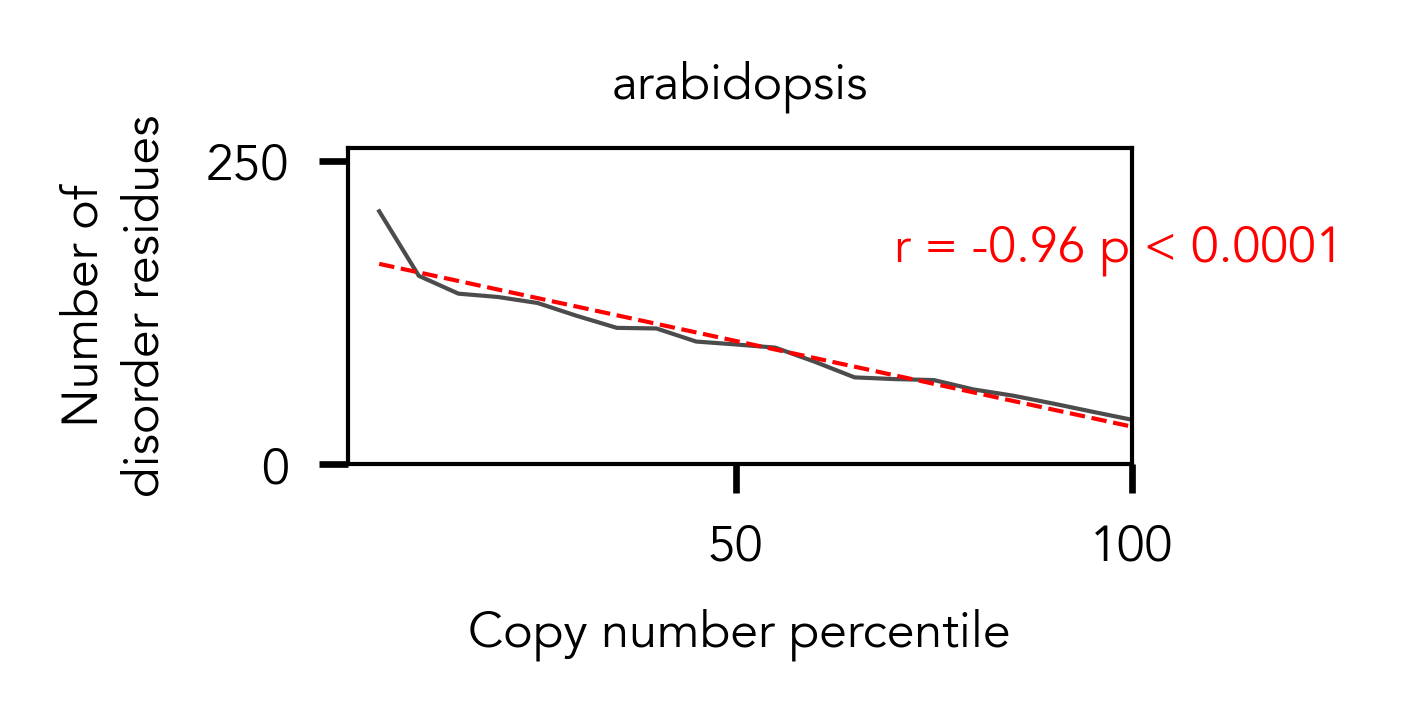

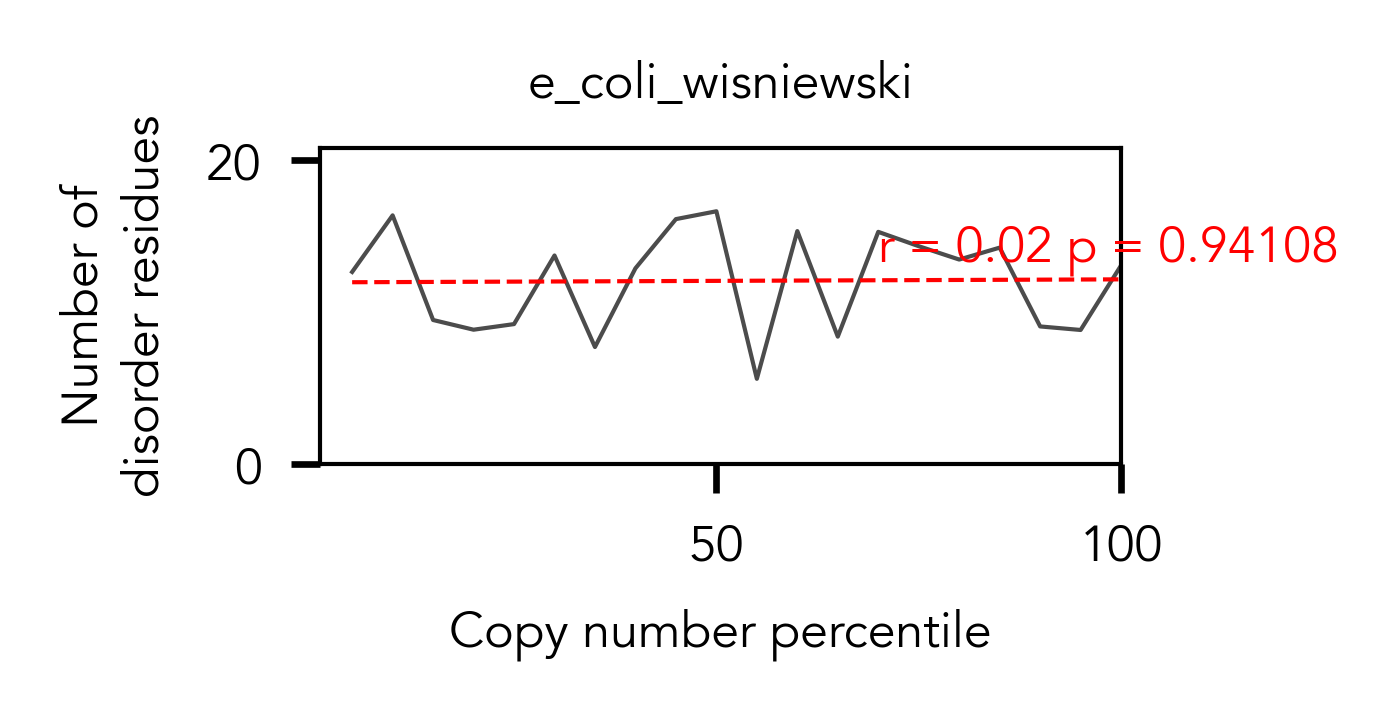

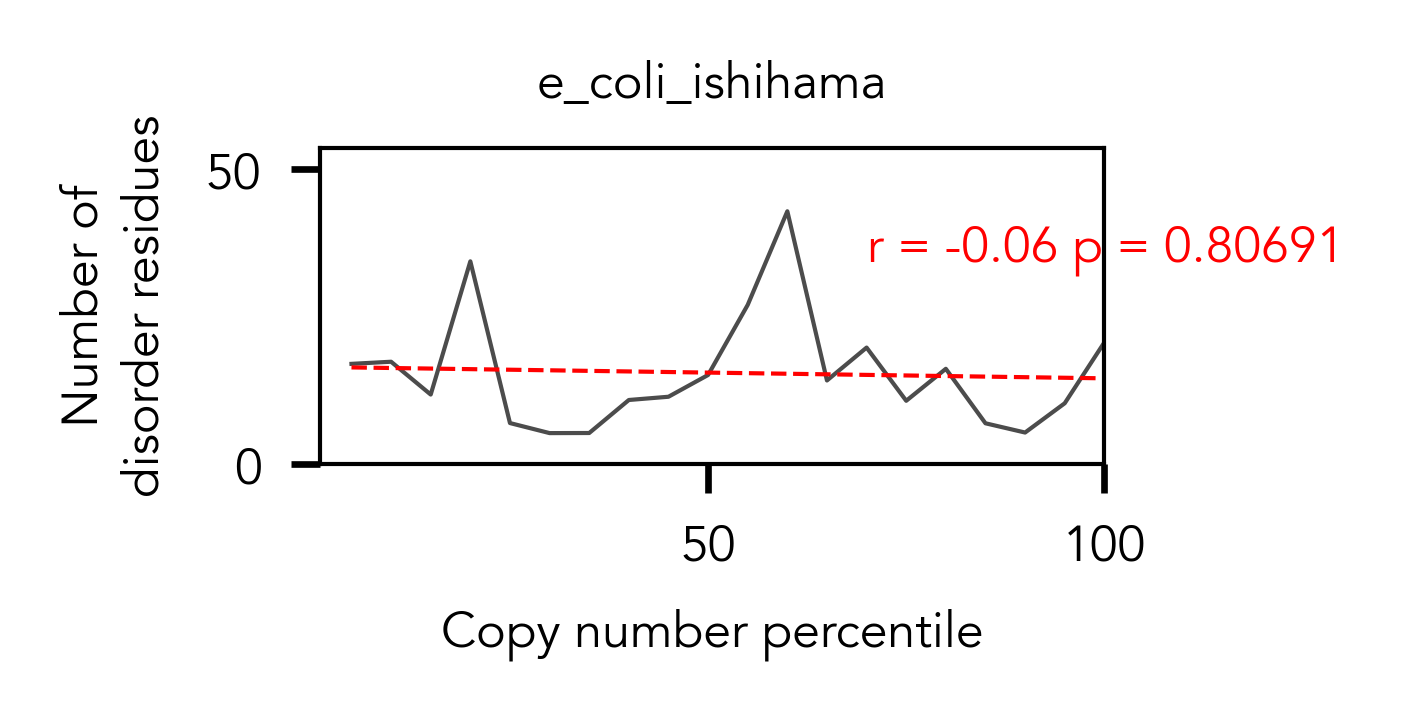

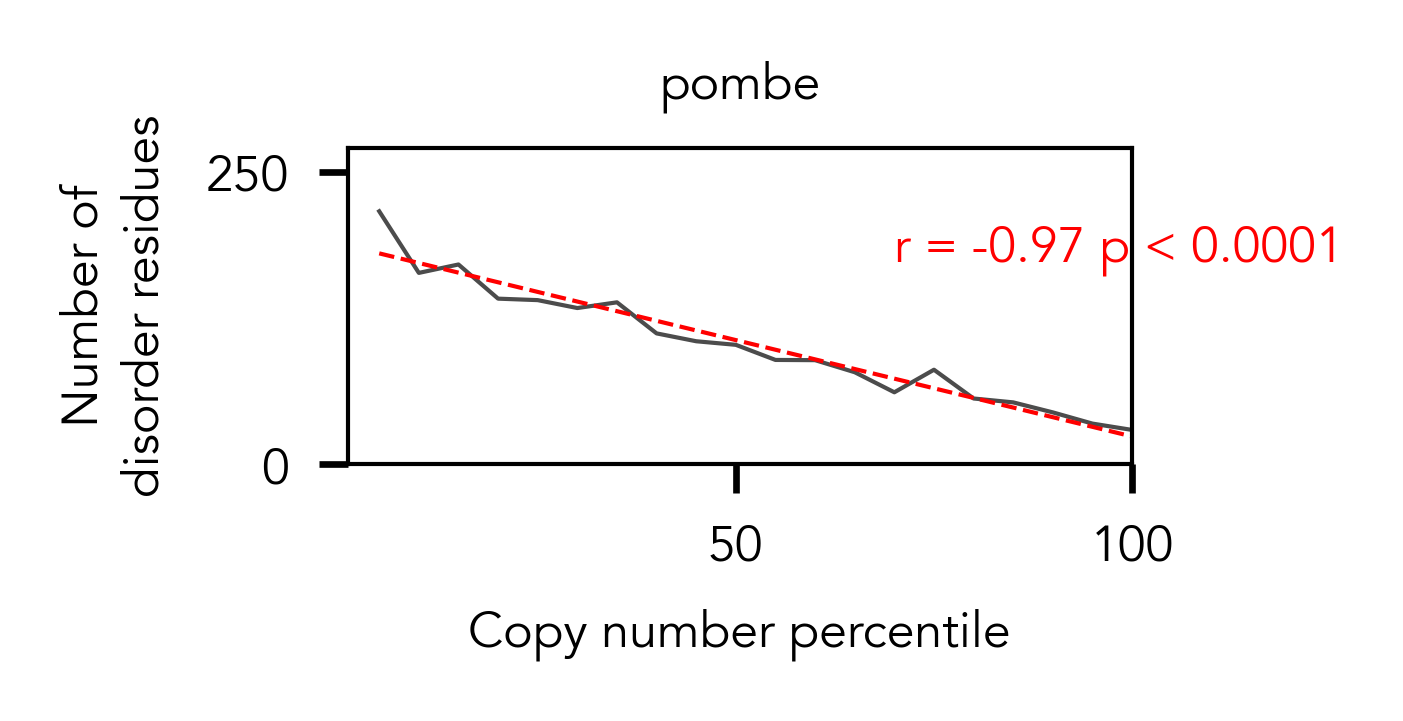

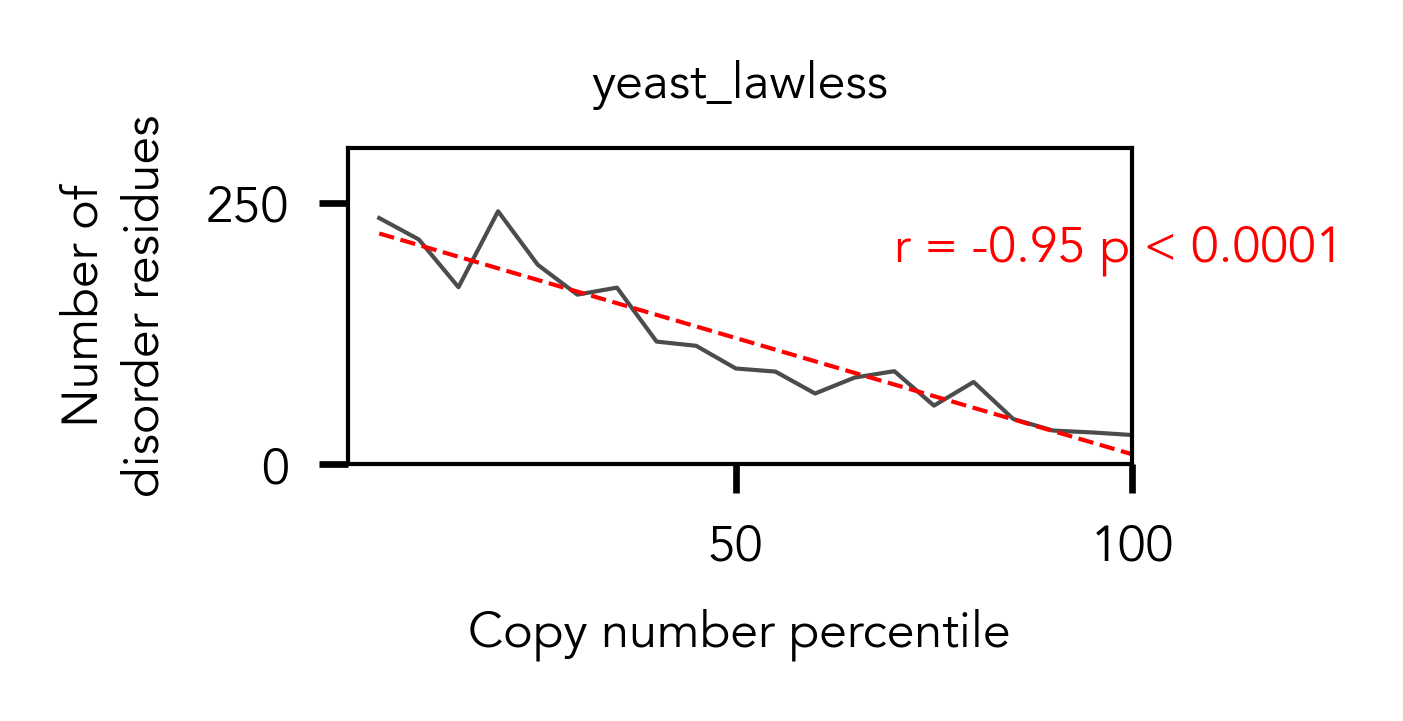

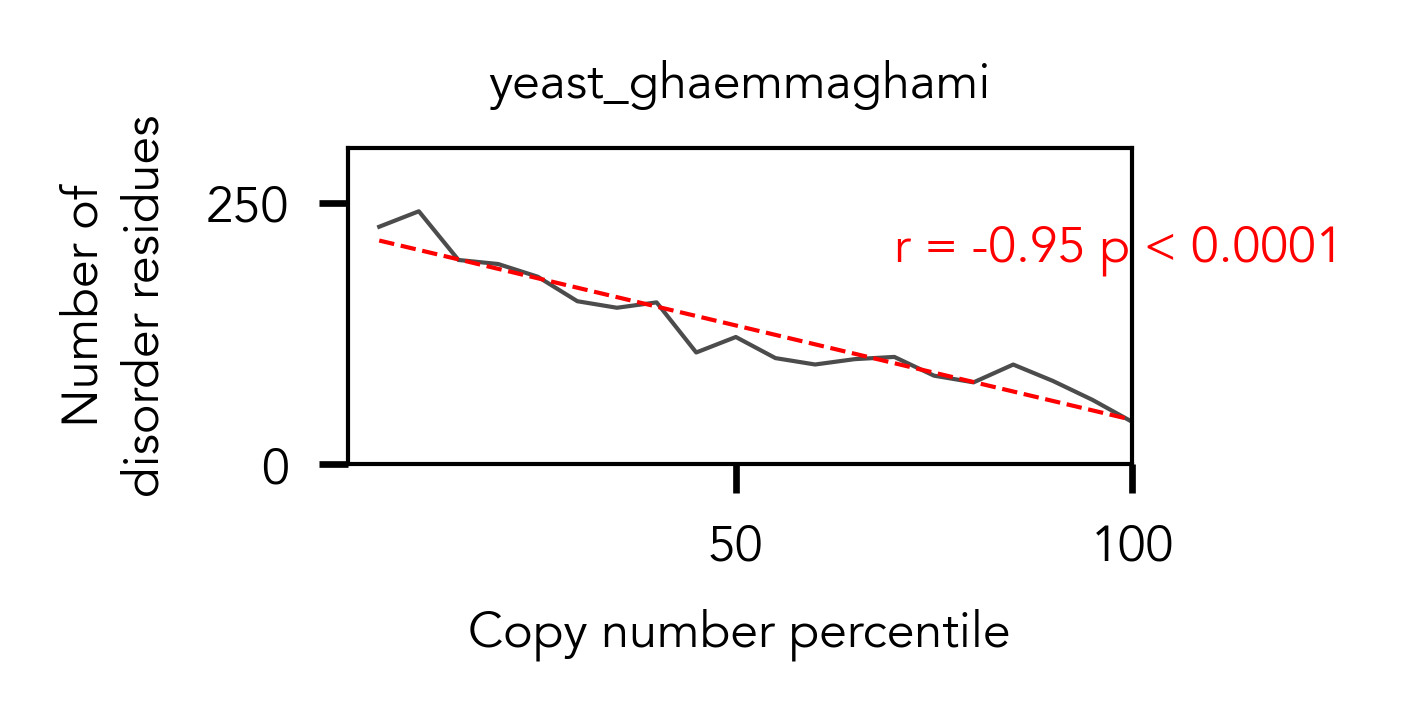

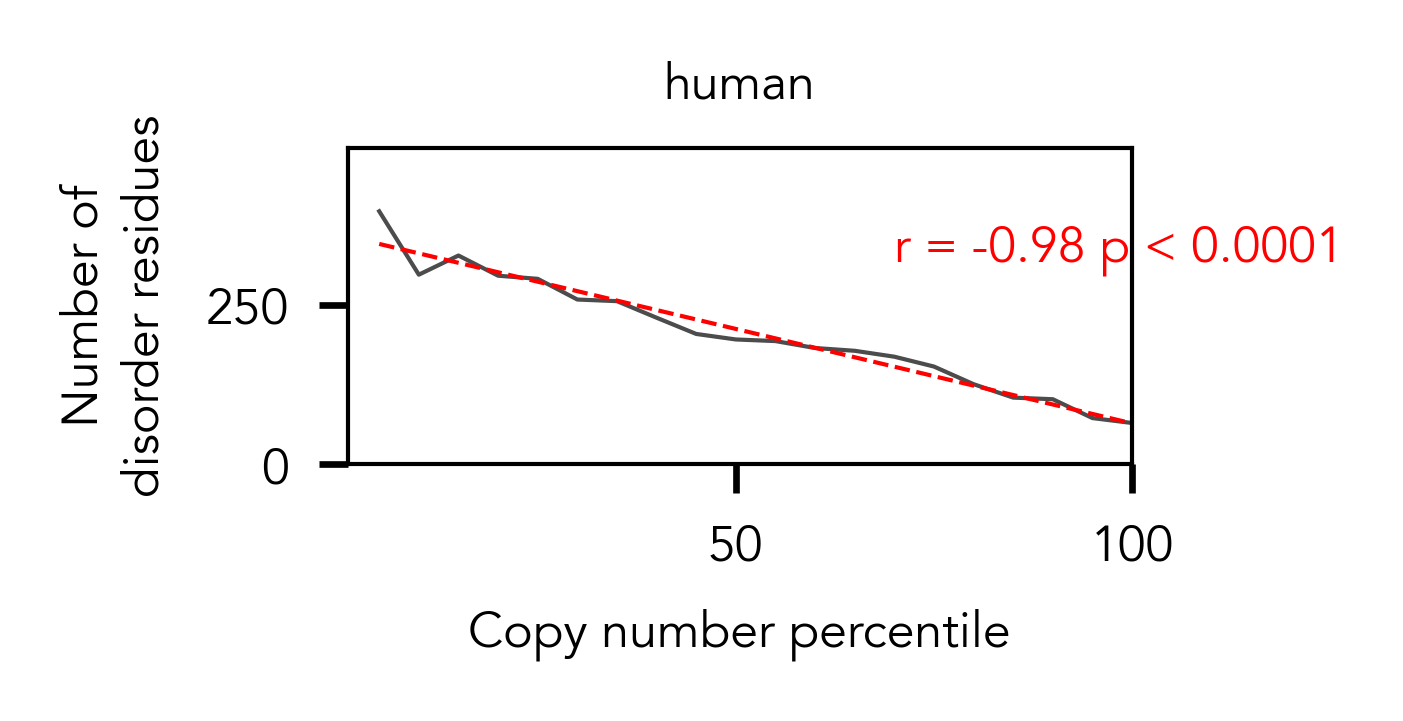

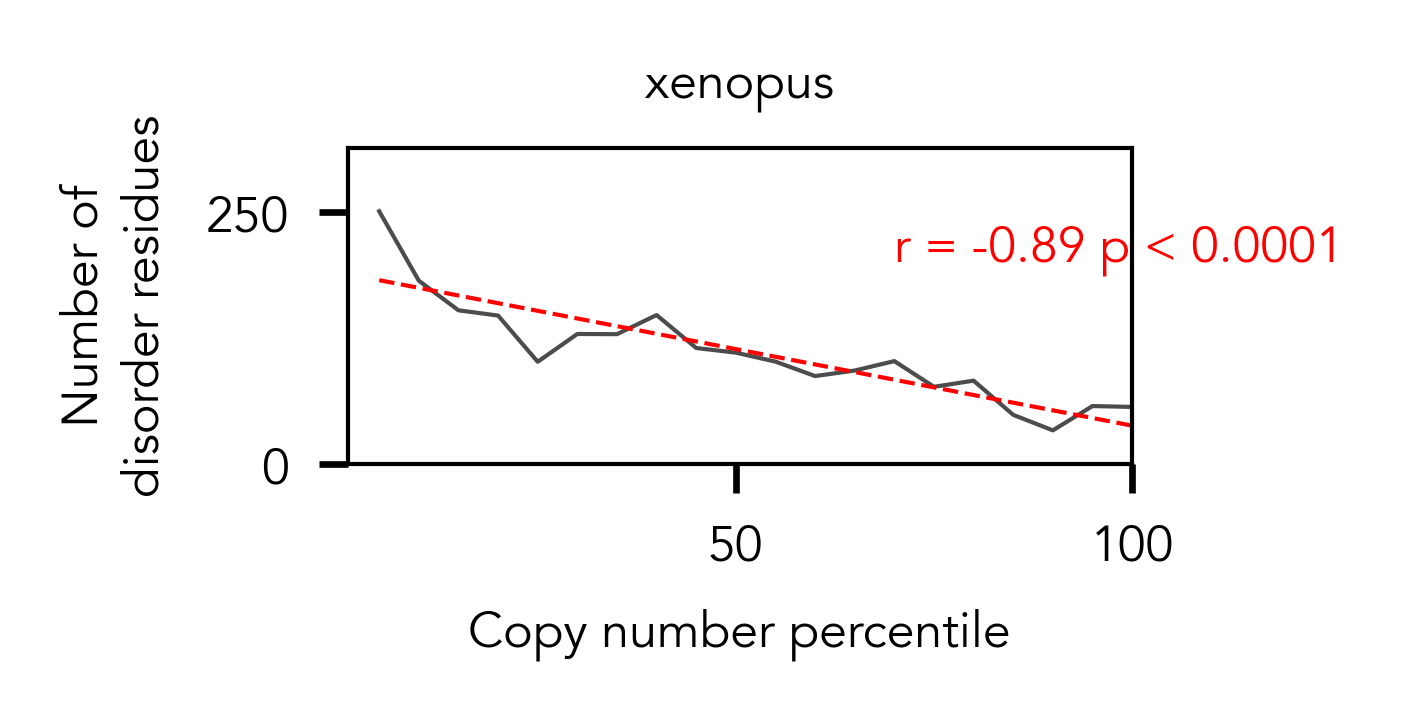

In [16]:
for organism in all_proteomes:
    figure(None, (2.3,1.3), dpi=300)

    target = all_mean_parameters[organism]['mean_disorder_count']

    plt.plot(percentile_idx, target, color='k',linewidth=0.5,ms=2,mec='k',mew=0.3,alpha=0.7)

    f = np.polyfit(percentile_idx,target,1)
    plt.plot(percentile_idx, f[0]*np.array(percentile_idx)+f[1], '--r',linewidth=0.5,ms=2,mec='k',mew=0.3)


    plt.xlabel('Copy number percentile',fontsize=6)
    plt.ylabel('Number of\ndisorder residues',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.title(organism,fontsize=6)
    plt.ylim([0,max(target)+0.25*max(target)])
    plt.xlim([1, 100])
    
    rval = np.round(scipy.stats.pearsonr(percentile_idx,target),2)[0]
    pval = scipy.stats.pearsonr(percentile_idx,target)[1]
    
    
    if pval < 0.0001:
        plt.text(70, max(target)*0.8, f'r = {rval} p < 0.0001',fontsize=6, color='r')
    else:
        plt.text(70, max(target)*0.8, f'r = {rval} p = {np.round(pval,5)}',fontsize=6, color='r')
    plt.tight_layout()
    print(scipy.stats.pearsonr(percentile_idx,target))
    
    plt.savefig(f'../FIGURES/copy_number/{organism}_number_disorder.pdf')
    

### Mean fraction disordered residues

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


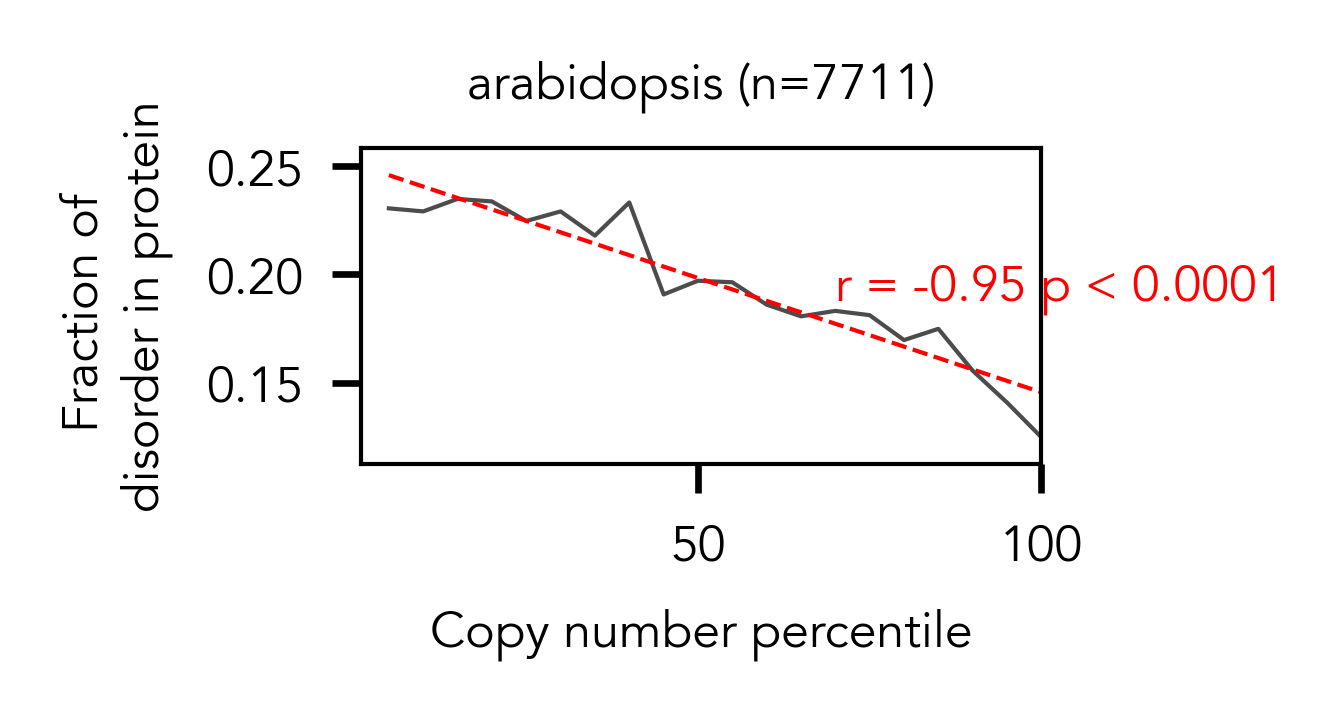

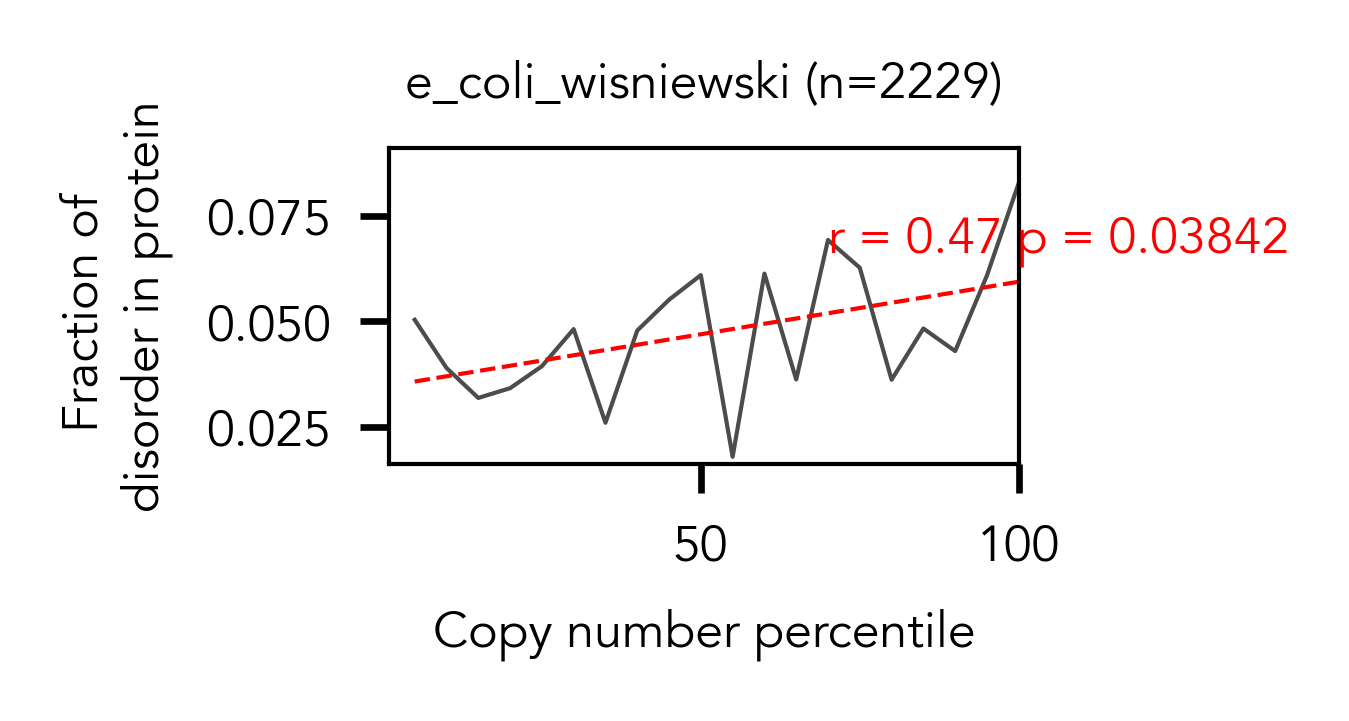

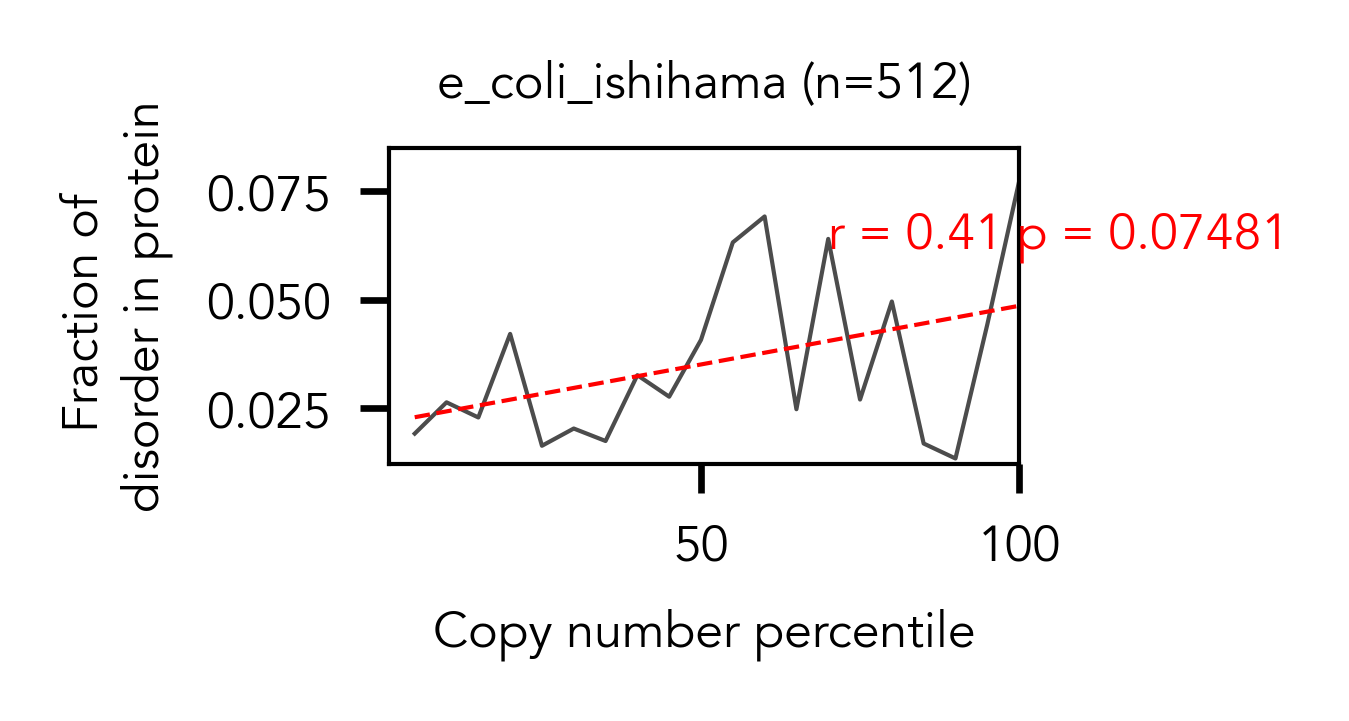

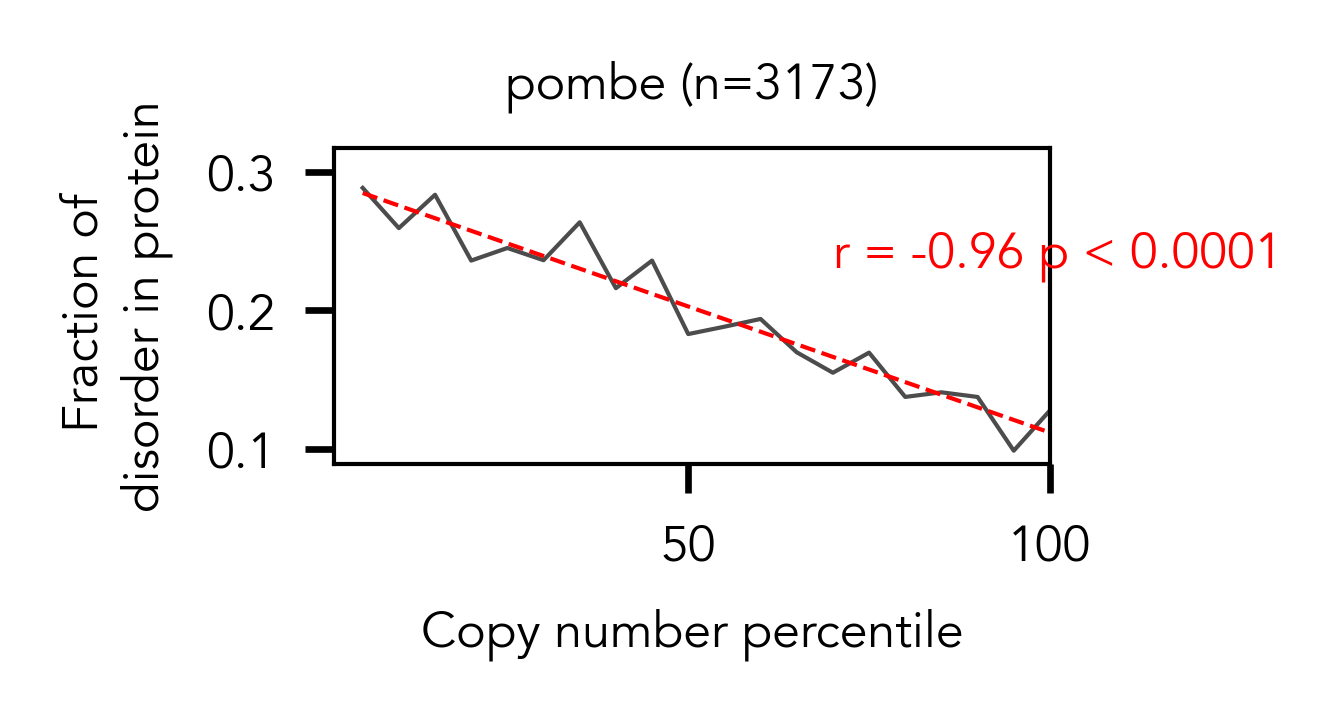

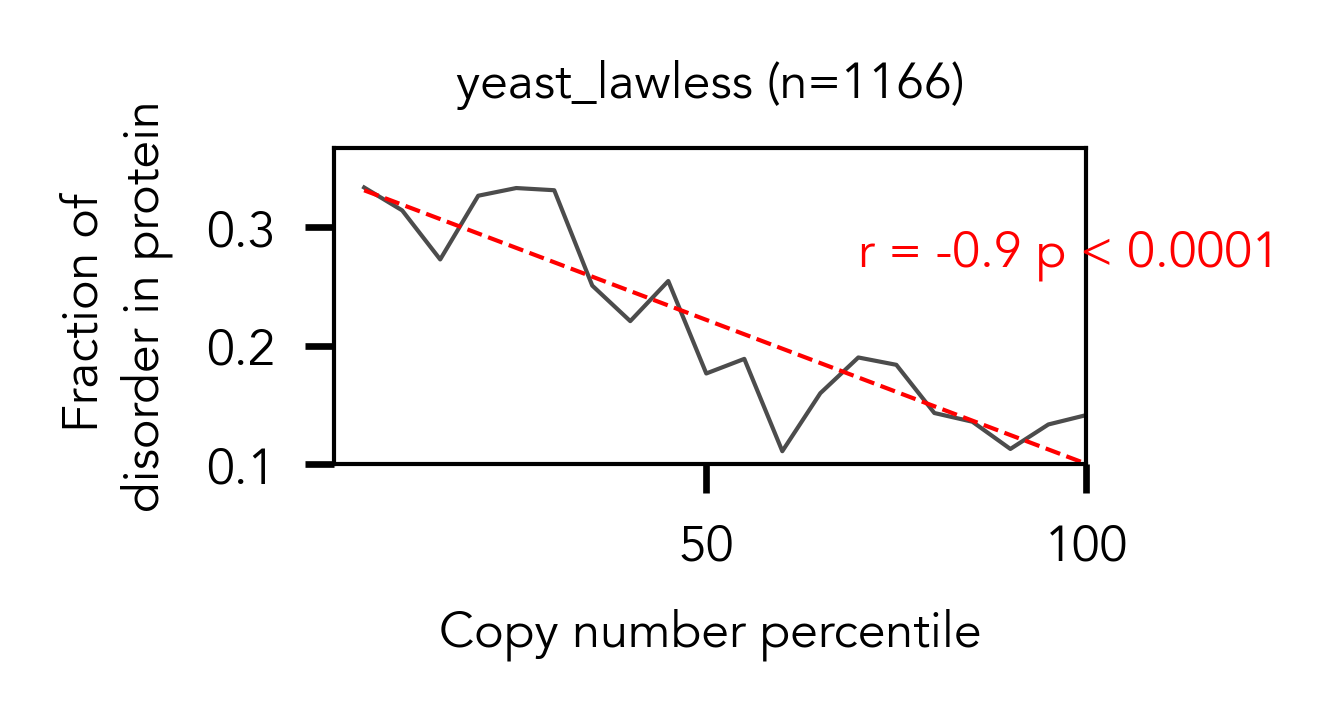

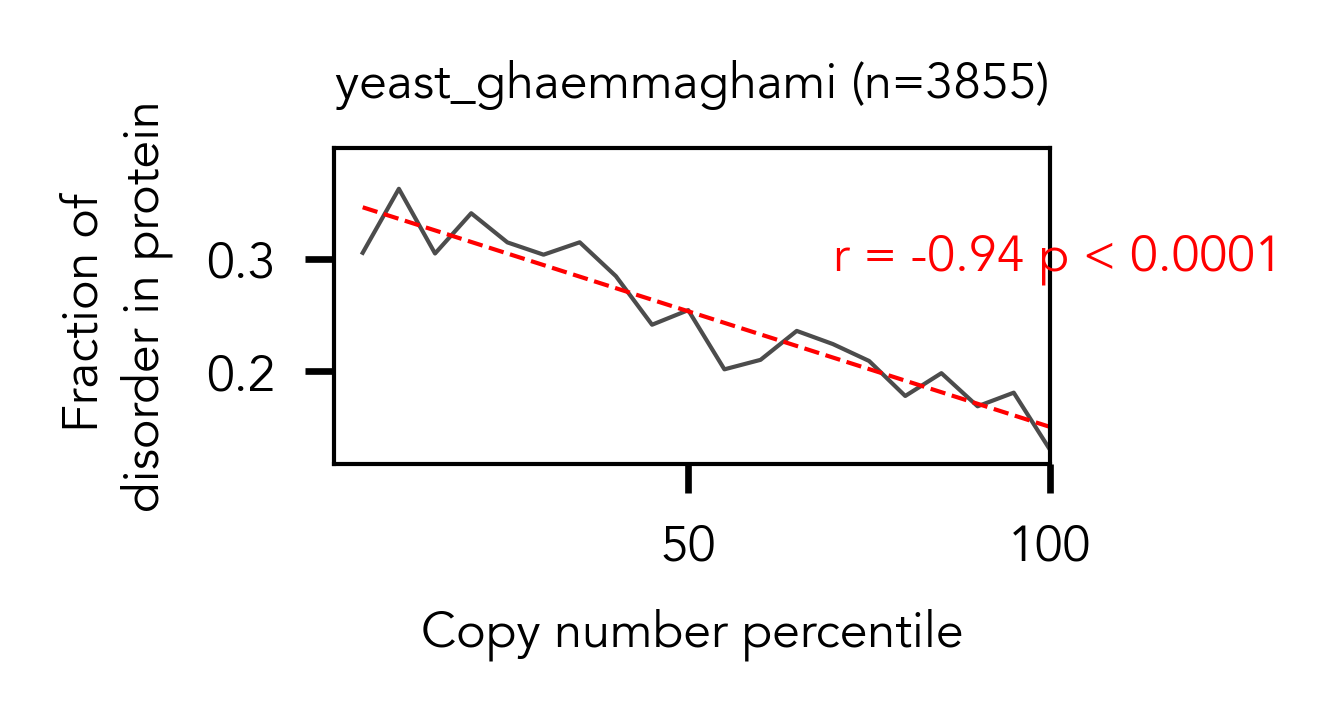

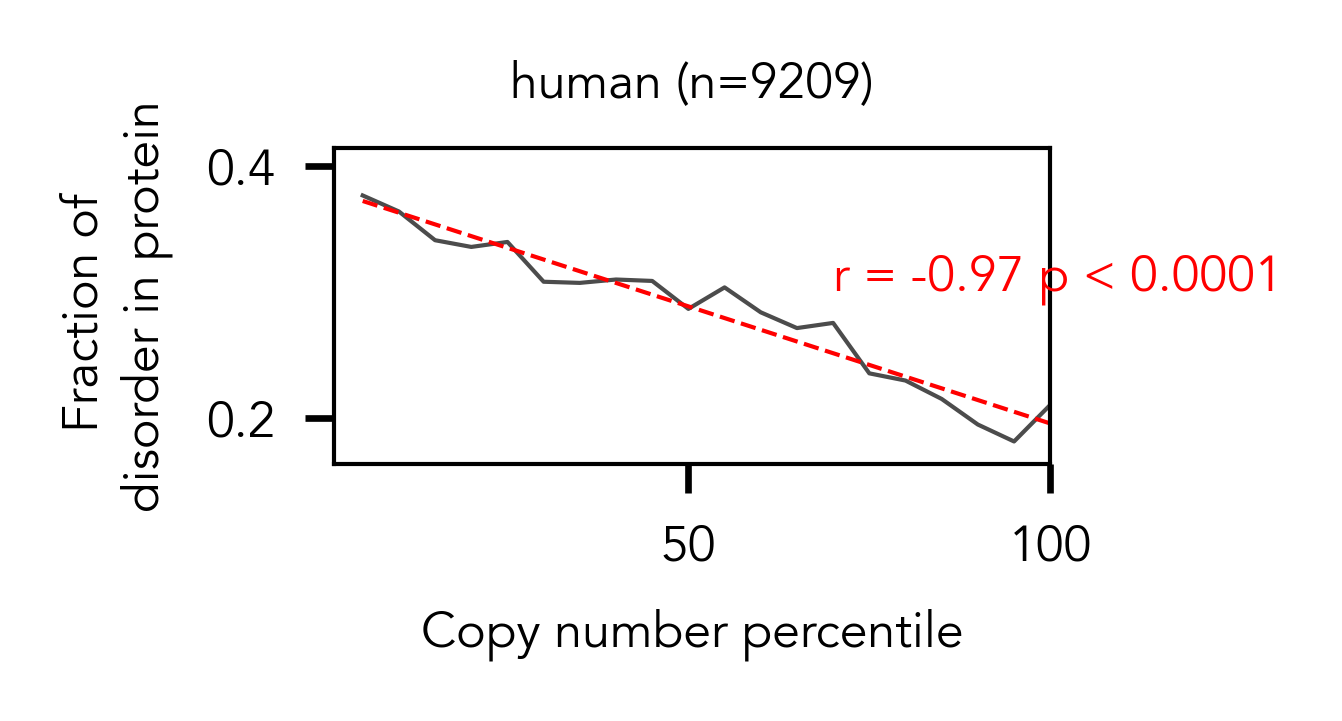

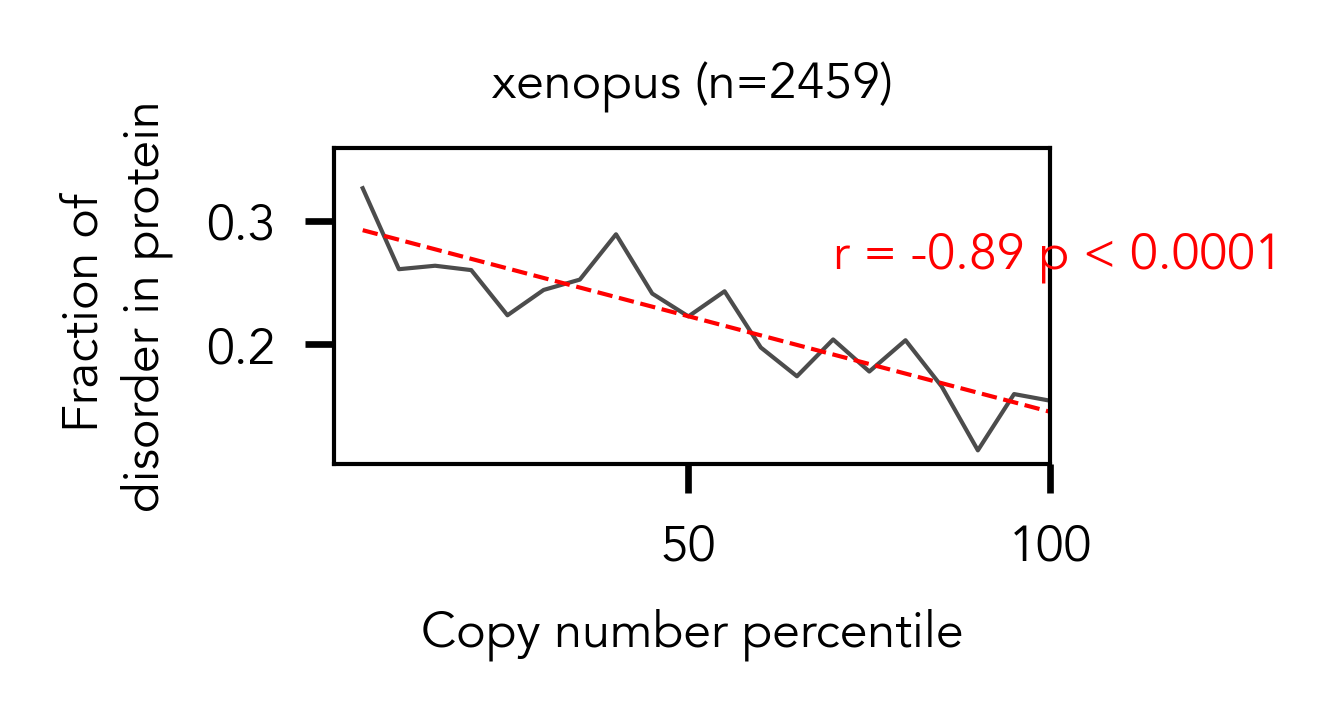

In [17]:
for organism in all_proteomes:
    figure(None, (2.3,1.3), dpi=300)

    target = all_mean_parameters[organism]['mean_disorder_fraction']

    plt.plot(percentile_idx, target, color='k',linewidth=0.5,ms=2,mec='k',mew=0.3,alpha=0.7)
    

    f = np.polyfit(percentile_idx,target,1)
    plt.plot(percentile_idx, f[0]*np.array(percentile_idx)+f[1], '--r',linewidth=0.5,ms=2,mec='k',mew=0.3)


    plt.xlabel('Copy number percentile',fontsize=6)
    plt.ylabel('Fraction of \ndisorder in protein',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.title(f'{organism} (n={len(all_proteomes[organism])})',fontsize=6)
    plt.ylim([min(target)-0.1*min(target),max(target)+0.1*max(target)])
    plt.xlim([1, 100])
    
    
    rval = np.round(scipy.stats.pearsonr(percentile_idx,target),2)[0]
    pval = scipy.stats.pearsonr(percentile_idx,target)[1]
    
    if pval < 0.0001:
        plt.text(70, max(target)*0.8, f'r = {rval} p < 0.0001',fontsize=6, color='r')
    else:
        plt.text(70, max(target)*0.8, f'r = {rval} p = {np.round(pval,5)}',fontsize=6, color='r')
    plt.tight_layout()

    
    #plt.text(70, max(target)*0.8, f'r = {np.round(np.corrcoef(percentile_idx,target)[0][1],2)}',fontsize=6, color='r')
    plt.tight_layout()
    
    plt.savefig(f'../FIGURES/copy_number/{organism}_disorder_fraction.pdf')
    
    

### Overall protein length

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


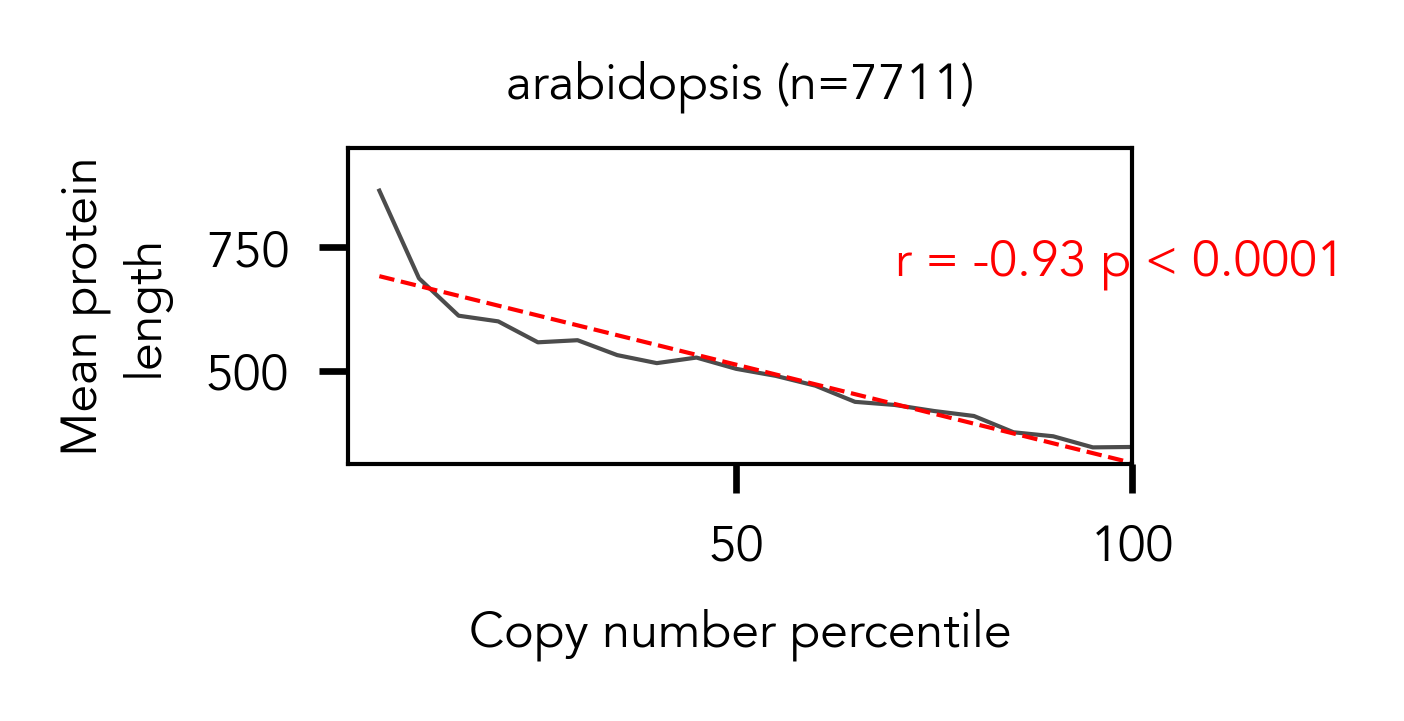

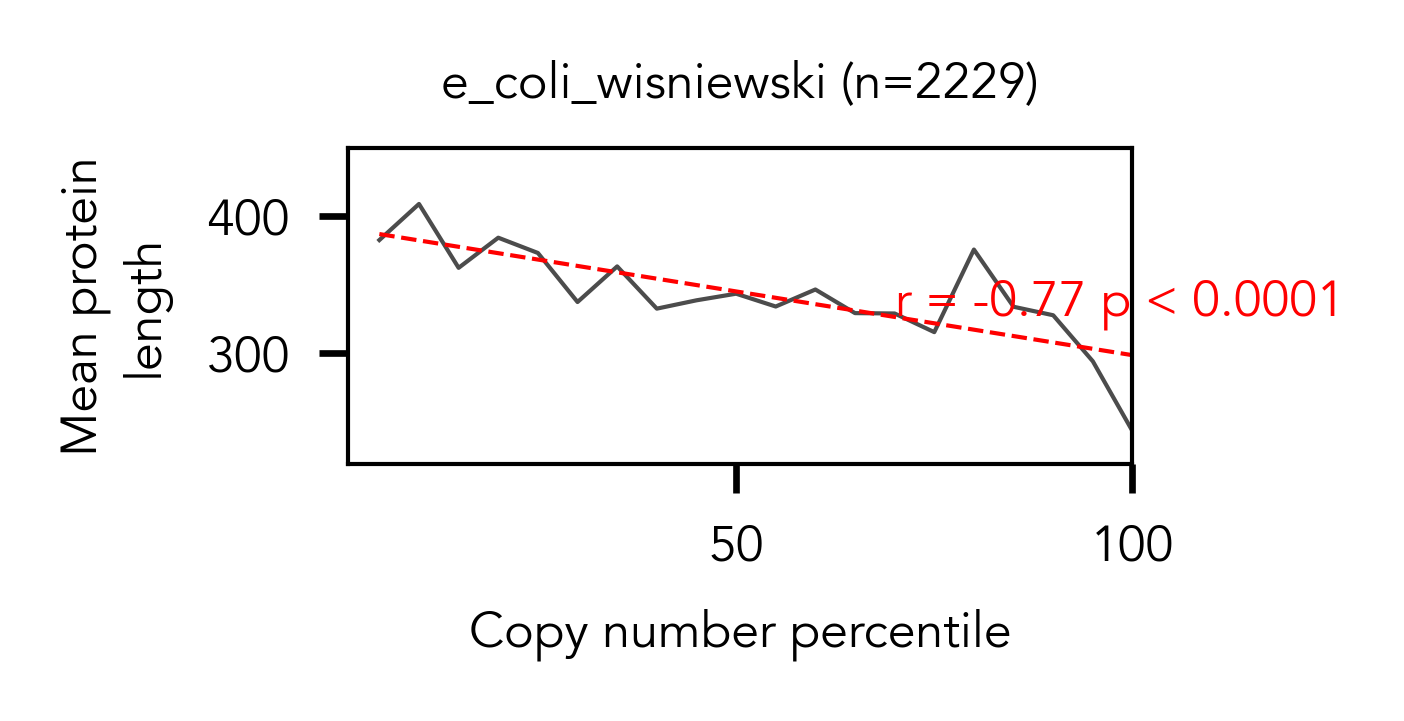

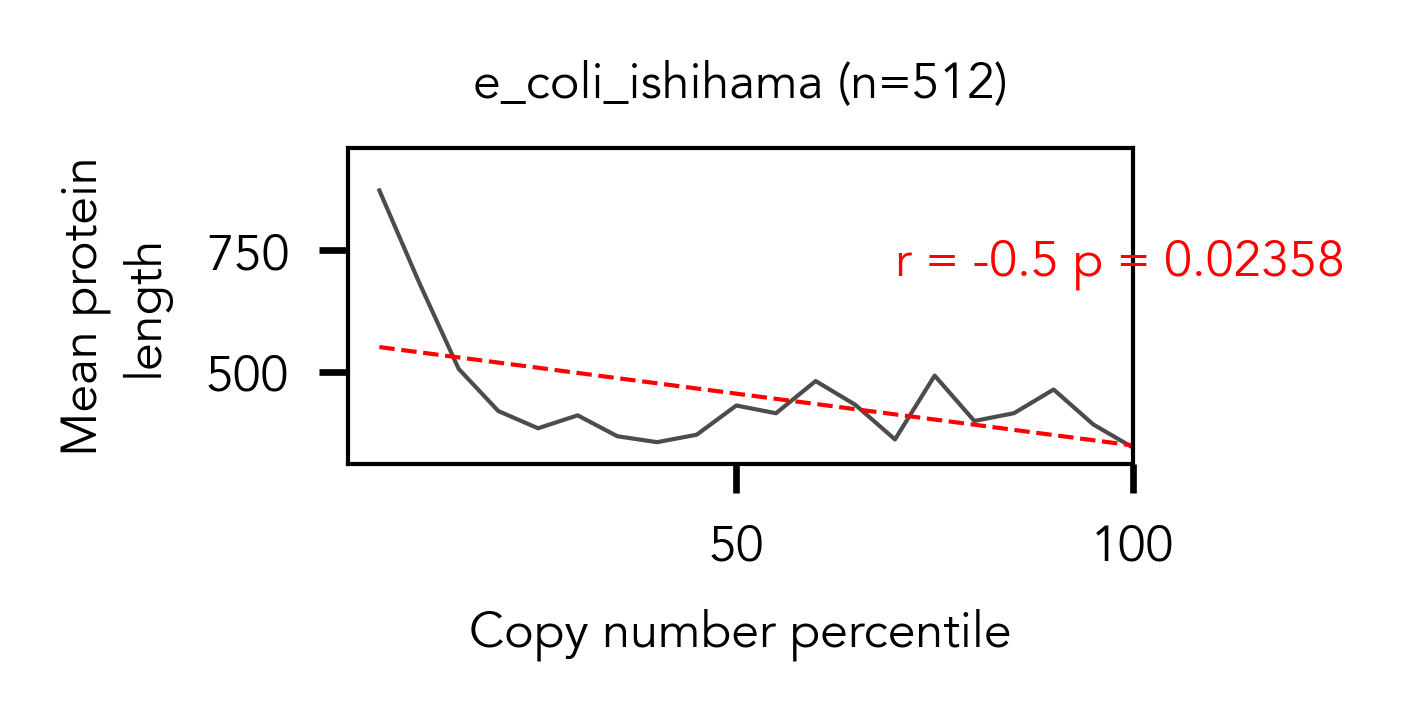

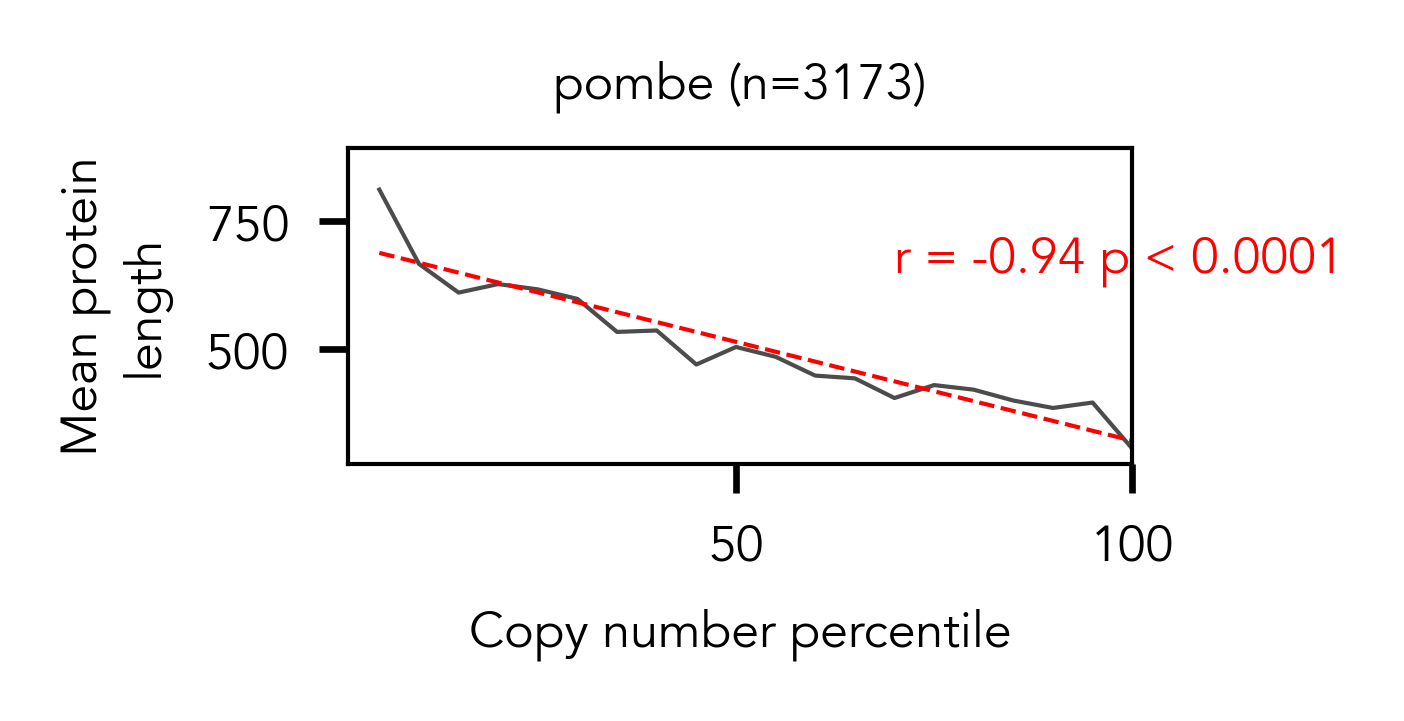

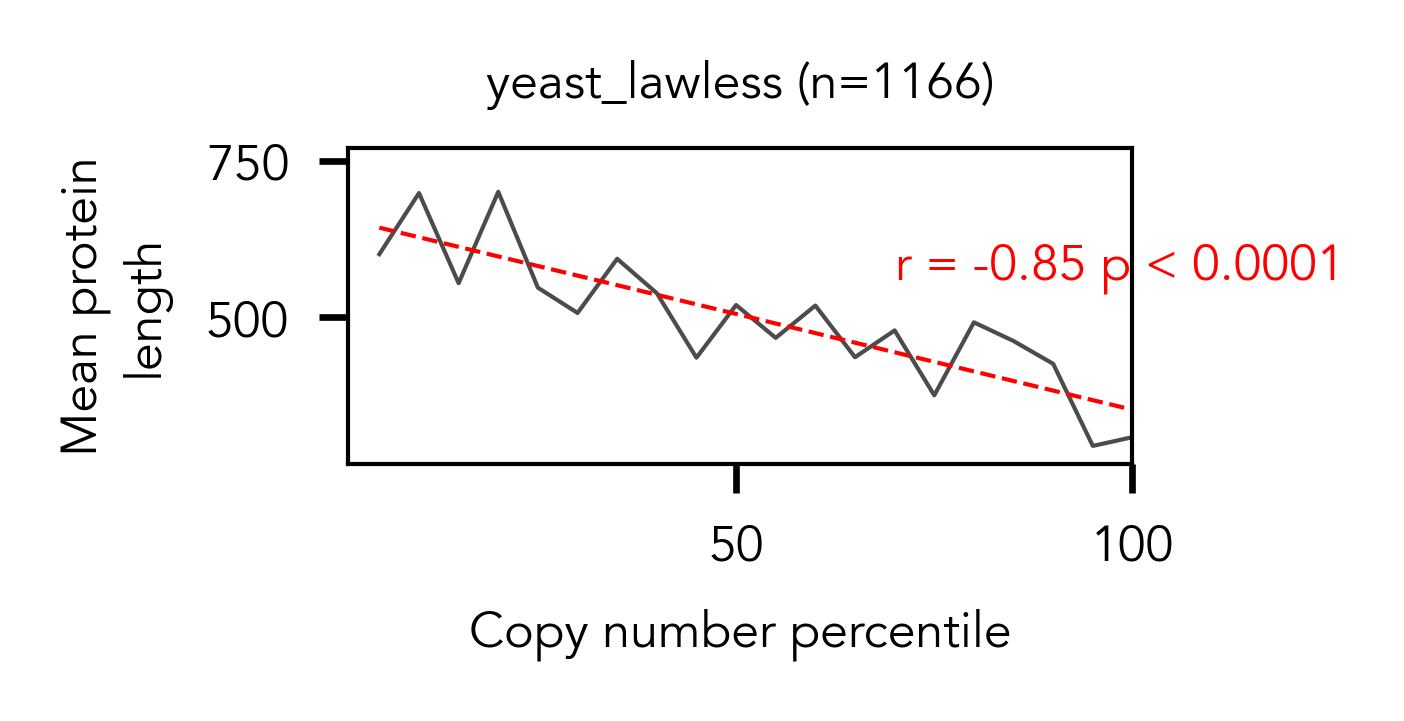

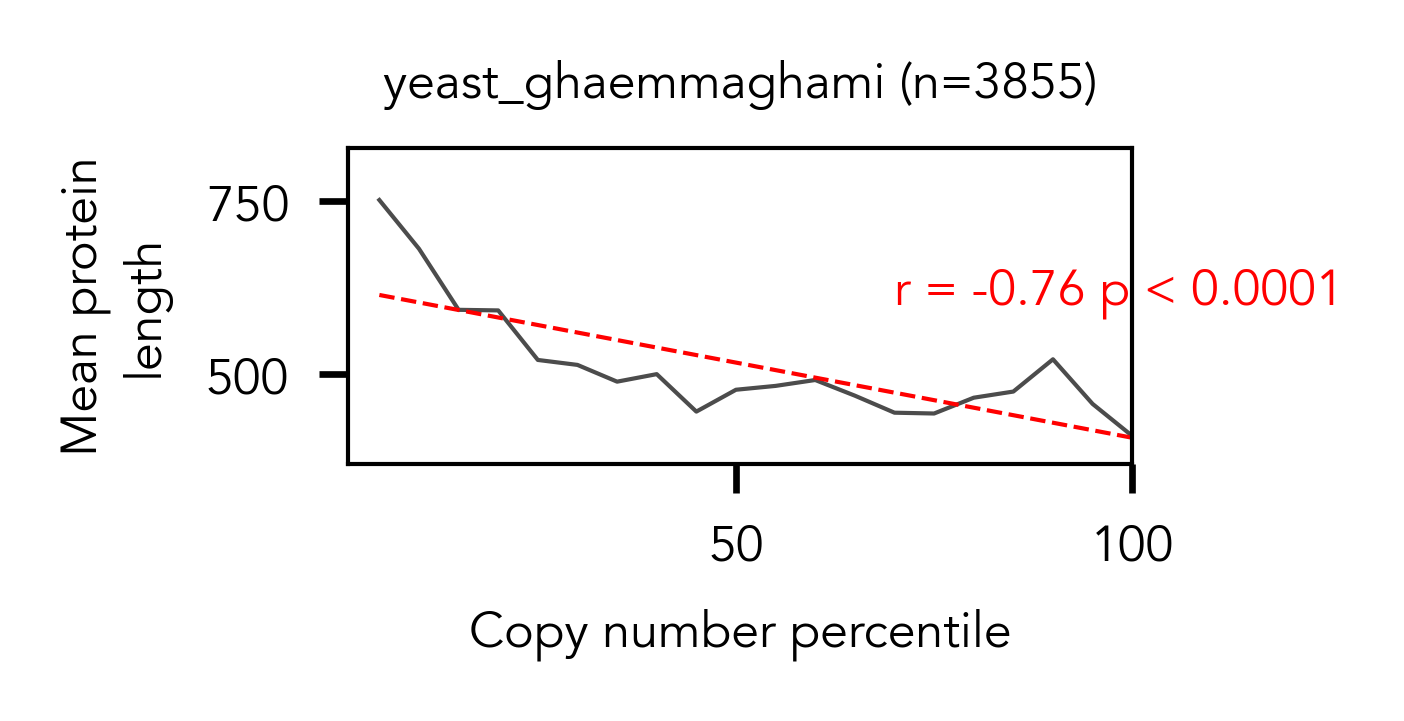

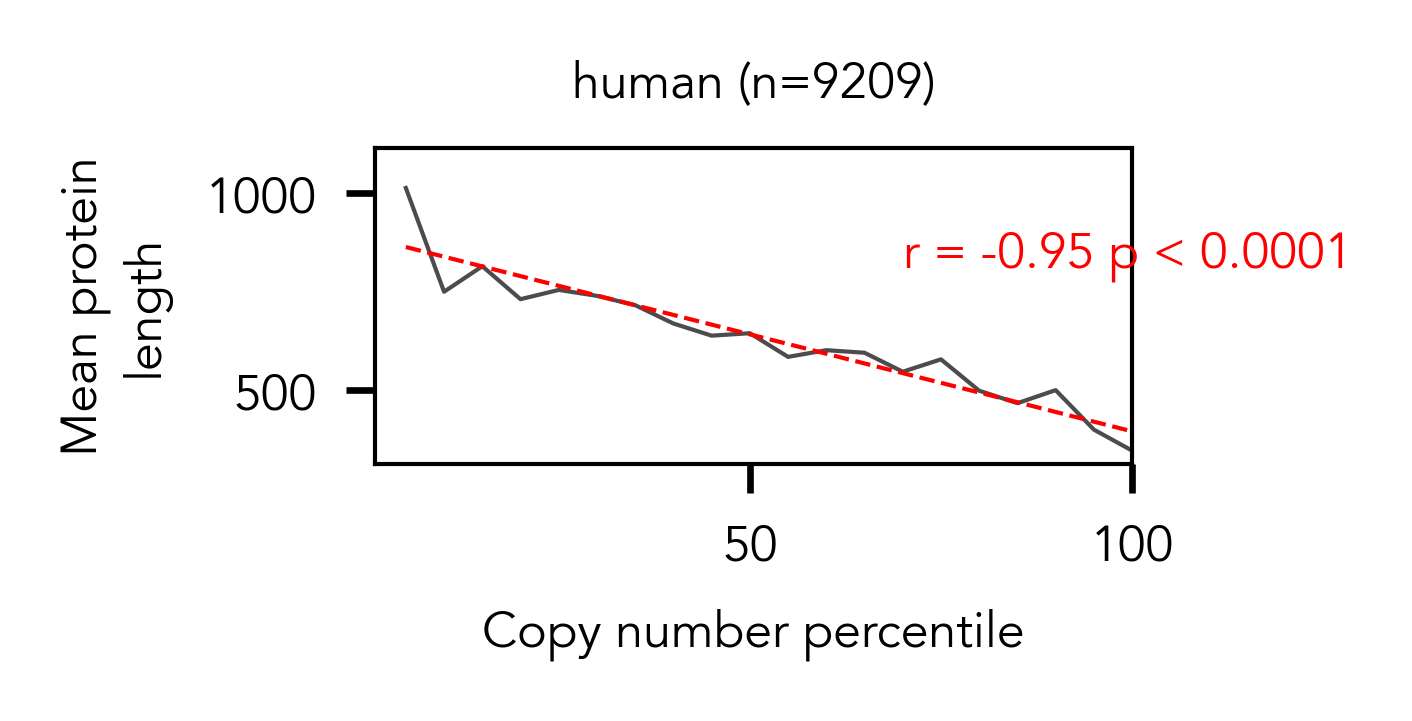

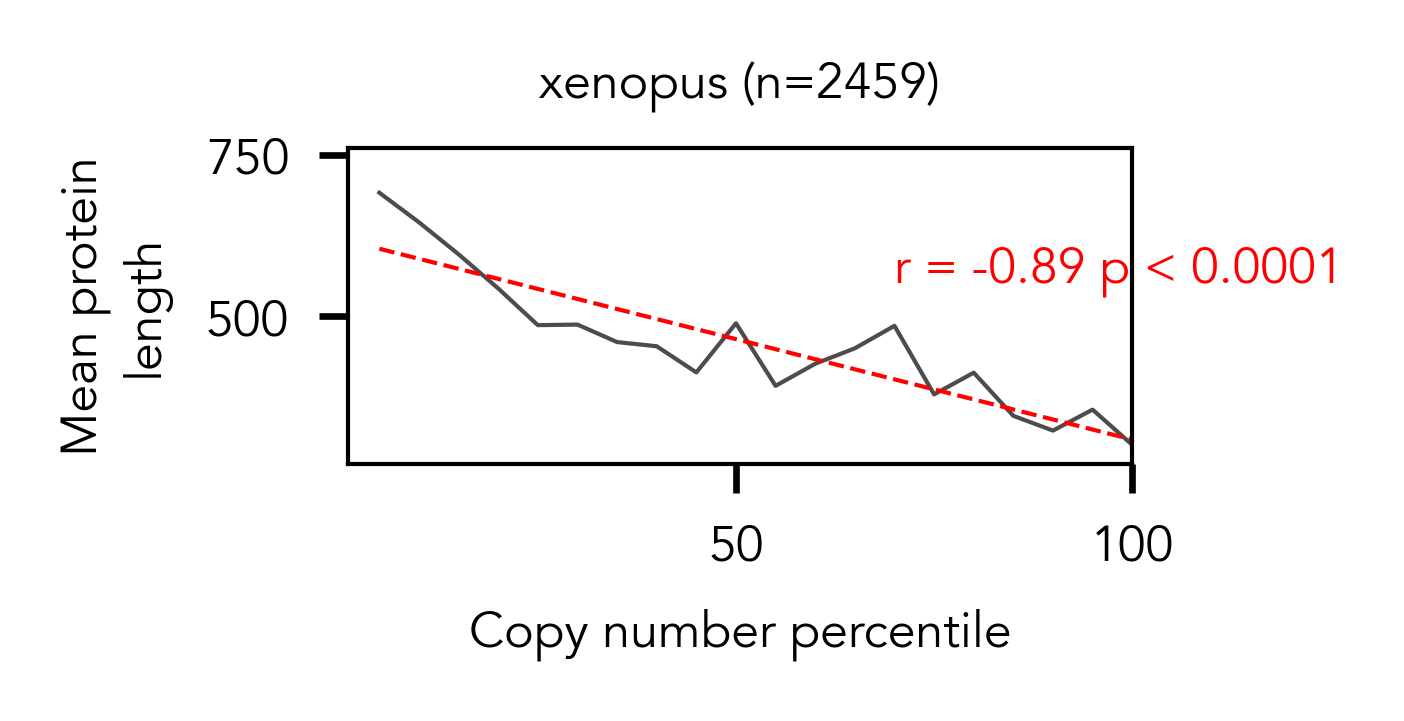

In [18]:
for organism in all_proteomes:
    figure(None, (2.3,1.3), dpi=300)

    target = all_mean_parameters[organism]['mean_protein_length']

    plt.plot(percentile_idx, target, color='k',linewidth=0.5,ms=2,mec='k',mew=0.3,alpha=0.7)

    f = np.polyfit(percentile_idx,target,1)
    plt.plot(percentile_idx, f[0]*np.array(percentile_idx)+f[1], '--r',linewidth=0.5,ms=2,mec='k',mew=0.3)


    plt.xlabel('Copy number percentile',fontsize=6)
    plt.ylabel('Mean protein\nlength',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.title(f'{organism} (n={len(all_proteomes[organism])})',fontsize=6)
    
    plt.ylim([min(target)-0.1*min(target),max(target)+0.1*max(target)])
    plt.xlim([1, 100])    
    
    rval = np.round(scipy.stats.pearsonr(percentile_idx,target),2)[0]
    pval = scipy.stats.pearsonr(percentile_idx,target)[1]

    if pval < 0.0001:
        plt.text(70, max(target)*0.8, f'r = {rval} p < 0.0001',fontsize=6, color='r')
    else:
        plt.text(70, max(target)*0.8, f'r = {rval} p = {np.round(pval,5)}',fontsize=6, color='r')    
    
    #plt.text(70, max(target)*0.8, f'r = {np.round(np.corrcoef(percentile_idx,target)[0][1],2)}',fontsize=6, color='red')
    plt.tight_layout()
    
    plt.savefig(f'../FIGURES/copy_number/{organism}_mean_protein_len.pdf')
    
    
    

In [19]:

euks = ['arabidopsis', 'pombe', 'yeast_lawless', 'yeast_ghaemmaghami', 'human', 'xenopus']
        
        
        

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


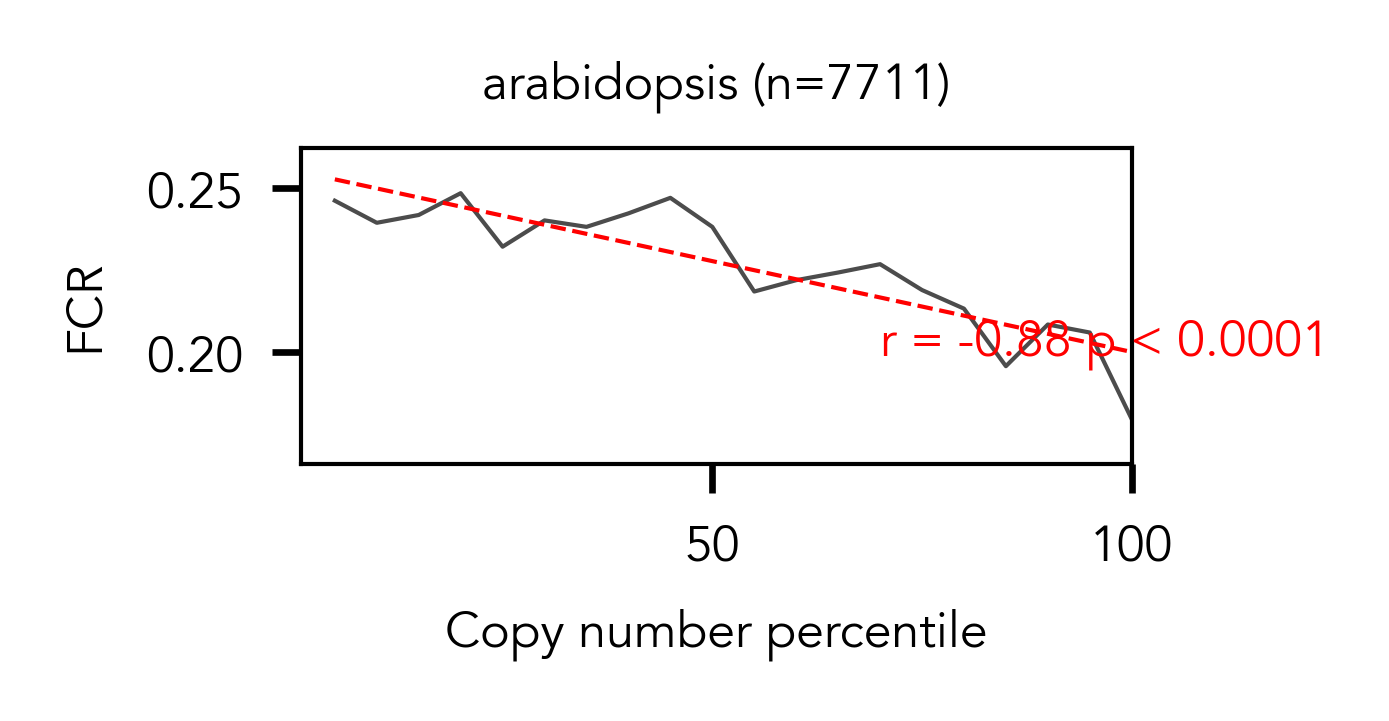

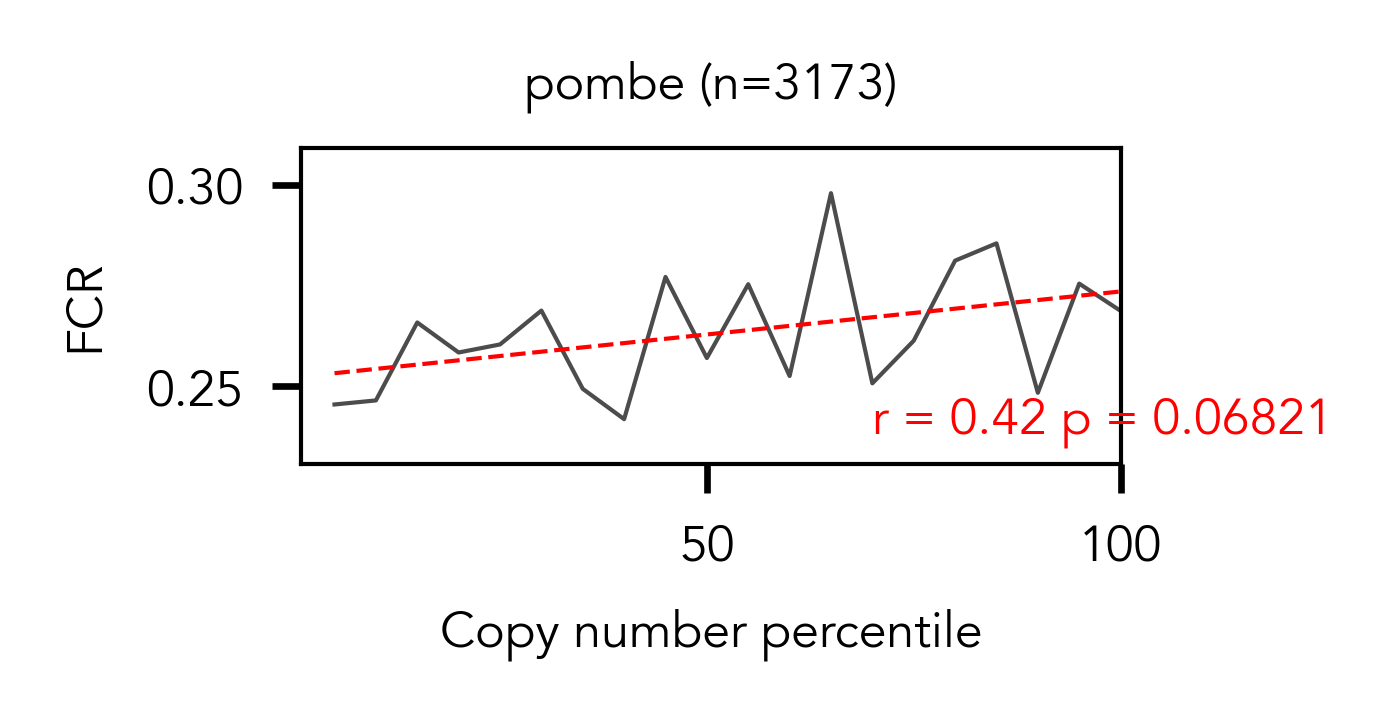

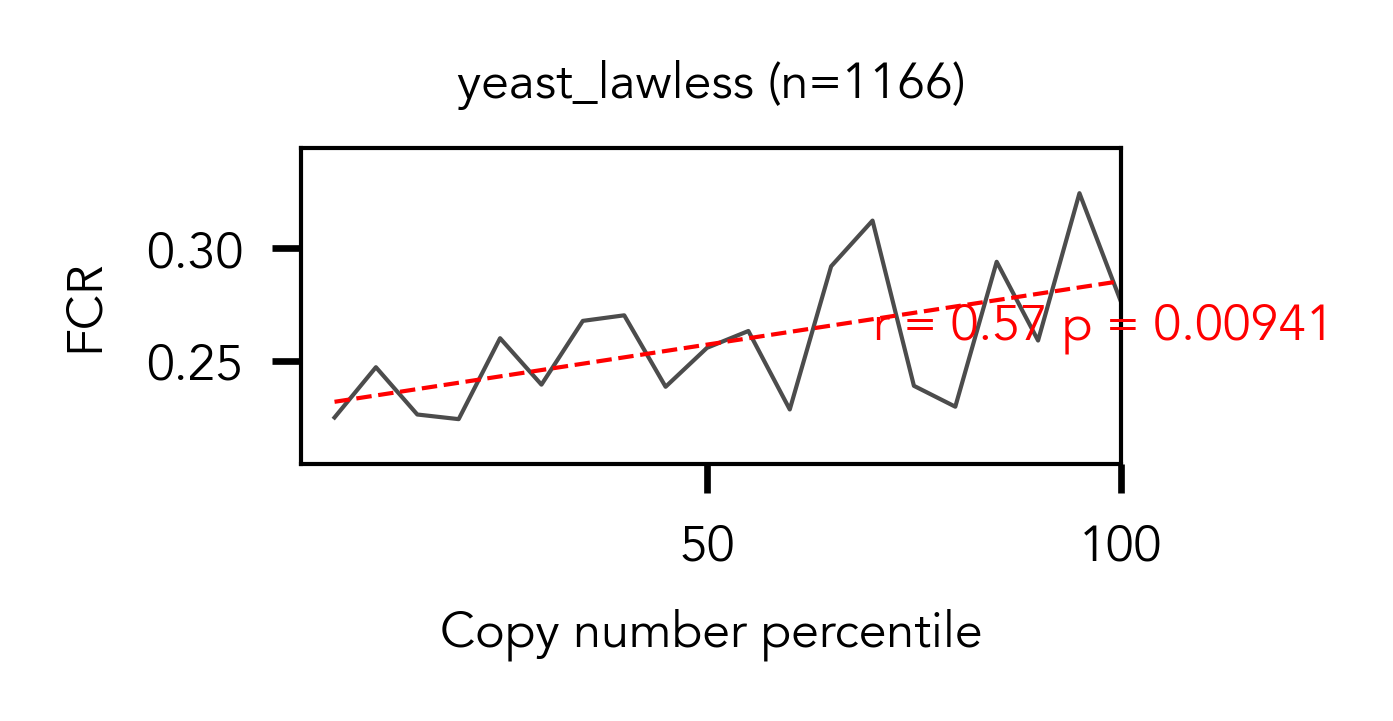

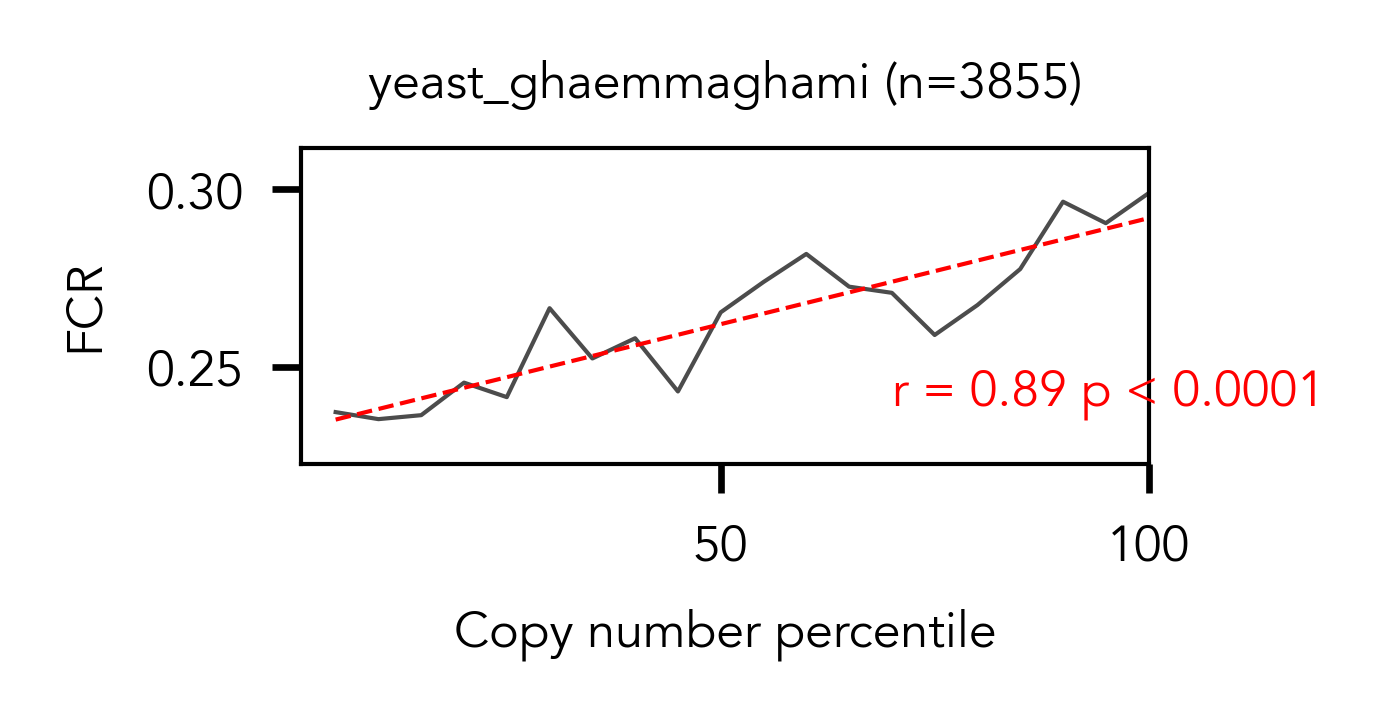

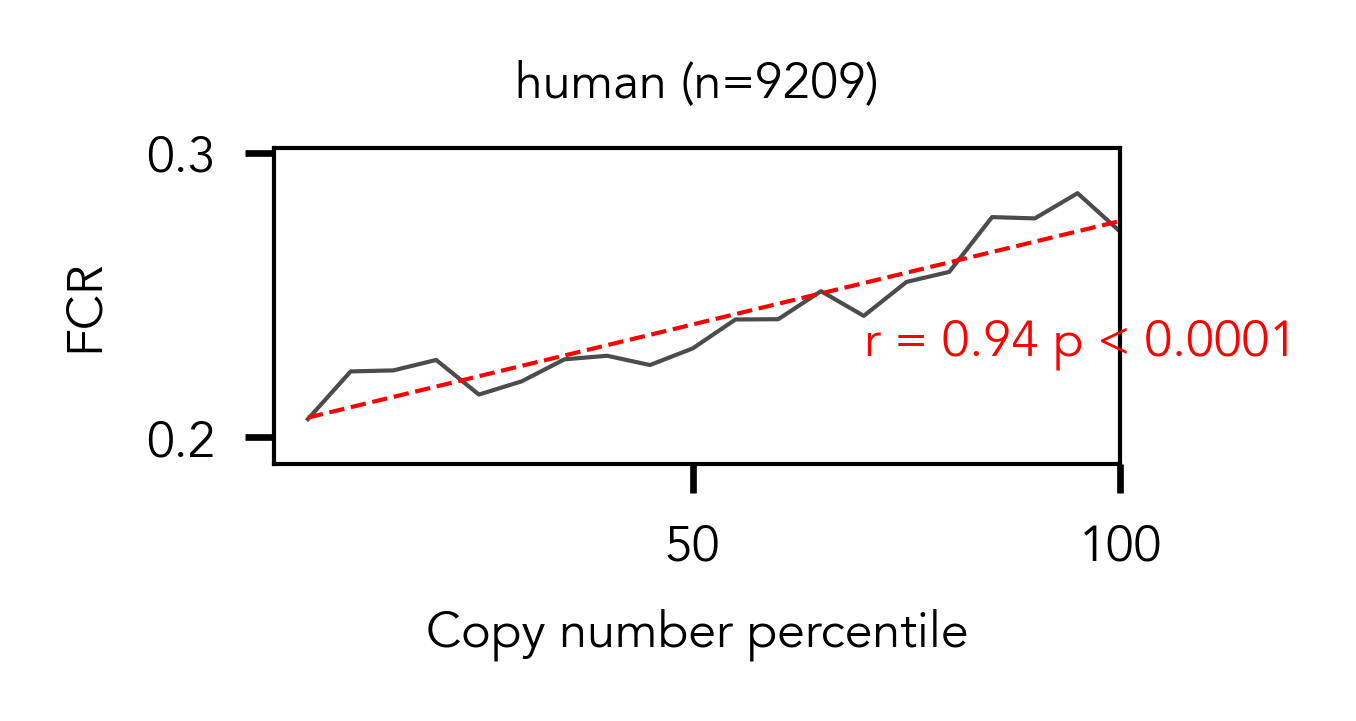

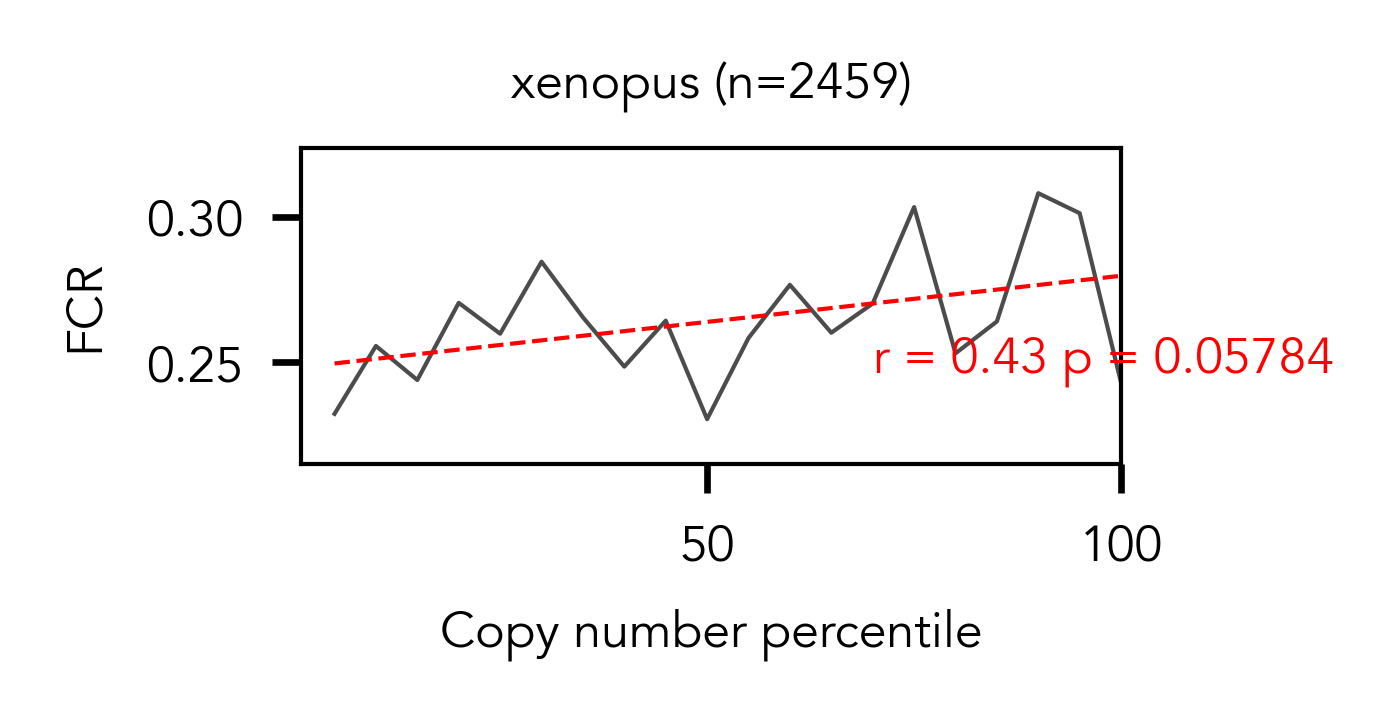

In [20]:
for organism in euks:
    figure(None, (2.3,1.3), dpi=300)

    target = all_mean_parameters[organism]['mean_idr_fcr']

    plt.plot(percentile_idx, target, color='k',linewidth=0.5,ms=2,mec='k',mew=0.3,alpha=0.7)

    f = np.polyfit(percentile_idx,target,1)
    plt.plot(percentile_idx, f[0]*np.array(percentile_idx)+f[1], '--r',linewidth=0.5,ms=2,mec='k',mew=0.3)


    plt.xlabel('Copy number percentile',fontsize=6)
    plt.ylabel('FCR',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.title(f'{organism} (n={len(all_proteomes[organism])})',fontsize=6)
    
    #plt.ylim([min(target)-0.1*min(target),max(target)+0.1*max(target)])
    
    plt.ylim([min(target)-((max(target)-min(target))*0.2), max(target)+((max(target)-min(target))*0.2)])
    plt.xlim([1, 100])    
    
    rval = np.round(scipy.stats.pearsonr(percentile_idx,target),2)[0]
    pval = scipy.stats.pearsonr(percentile_idx,target)[1]

    if pval < 0.0001:
        plt.text(70, max(target)*0.8, f'r = {rval} p < 0.0001',fontsize=6, color='r')
    else:
        plt.text(70, max(target)*0.8, f'r = {rval} p = {np.round(pval,5)}',fontsize=6, color='r')    
    
    #plt.text(70, max(target)*0.8, f'r = {np.round(np.corrcoef(percentile_idx,target)[0][1],2)}',fontsize=6, color='red')
    plt.tight_layout()
    
    plt.savefig(f'../FIGURES/copy_number/{organism}_idr_fcr.pdf')
    
    

# How does copy number influence absolute amino acid frequencies?
When we compute amino acid frequencies at proteome-wide scales, we assume that all proteins are present at the same copy number (i.e., each protein has an equal contribution to the number of residues).

This is, of course, not correct. By integrating *bona fide* copy number information, we can ask how the amino acid frequencies across the proteome and in IDRs change once we correct the copy number of different proteins.

In [21]:
valid_aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

name2nicename = {'arabidopsis':'A. Thaliana', 
                 'e_coli_wisniewski': 'E. coli',
                 'pombe': 'S. pombe',
                 'yeast_lawless' :'S. cerevisiae (2016)',
                 'yeast_ghaemmaghami' :'S. cerevisiae (2003)',
                 'human':'H. sapiens',
                 'xenopus': 'X. laevis'}

In [22]:

names = list(all_proteomes.keys())

# we remove the ishihama dataset because at ~500 proteins it is a little
# small and introduces some spurious results
names.remove('e_coli_ishihama')
namesnice = [name2nicename[n] for n in names]


all_aa_counts_niave = []
all_aa_counts_cn = []

for organism in names:
    proteome = all_proteomes[organism]


    counts = []
    for protein in proteome:
        counts.append([protein.sequence.count(i) for i in valid_aa])
        
    all_aa_counts_niave.append(np.sum(counts,0)/np.sum(counts).tolist())

    counts = []
    for protein in proteome:
        counts.append([protein.sequence.count(i)*protein.attribute('copy_number') for i in valid_aa])
        
    all_aa_counts_cn.append(np.sum(counts,0)/np.sum(counts).tolist())
    
    

### Copy number correction 
log2-fold correction shows that in general there proteins with glycine, lysine, and alanine tend to be more well-represented after copy-number correction while proteins with glutamine, serine and cysteine are less freque

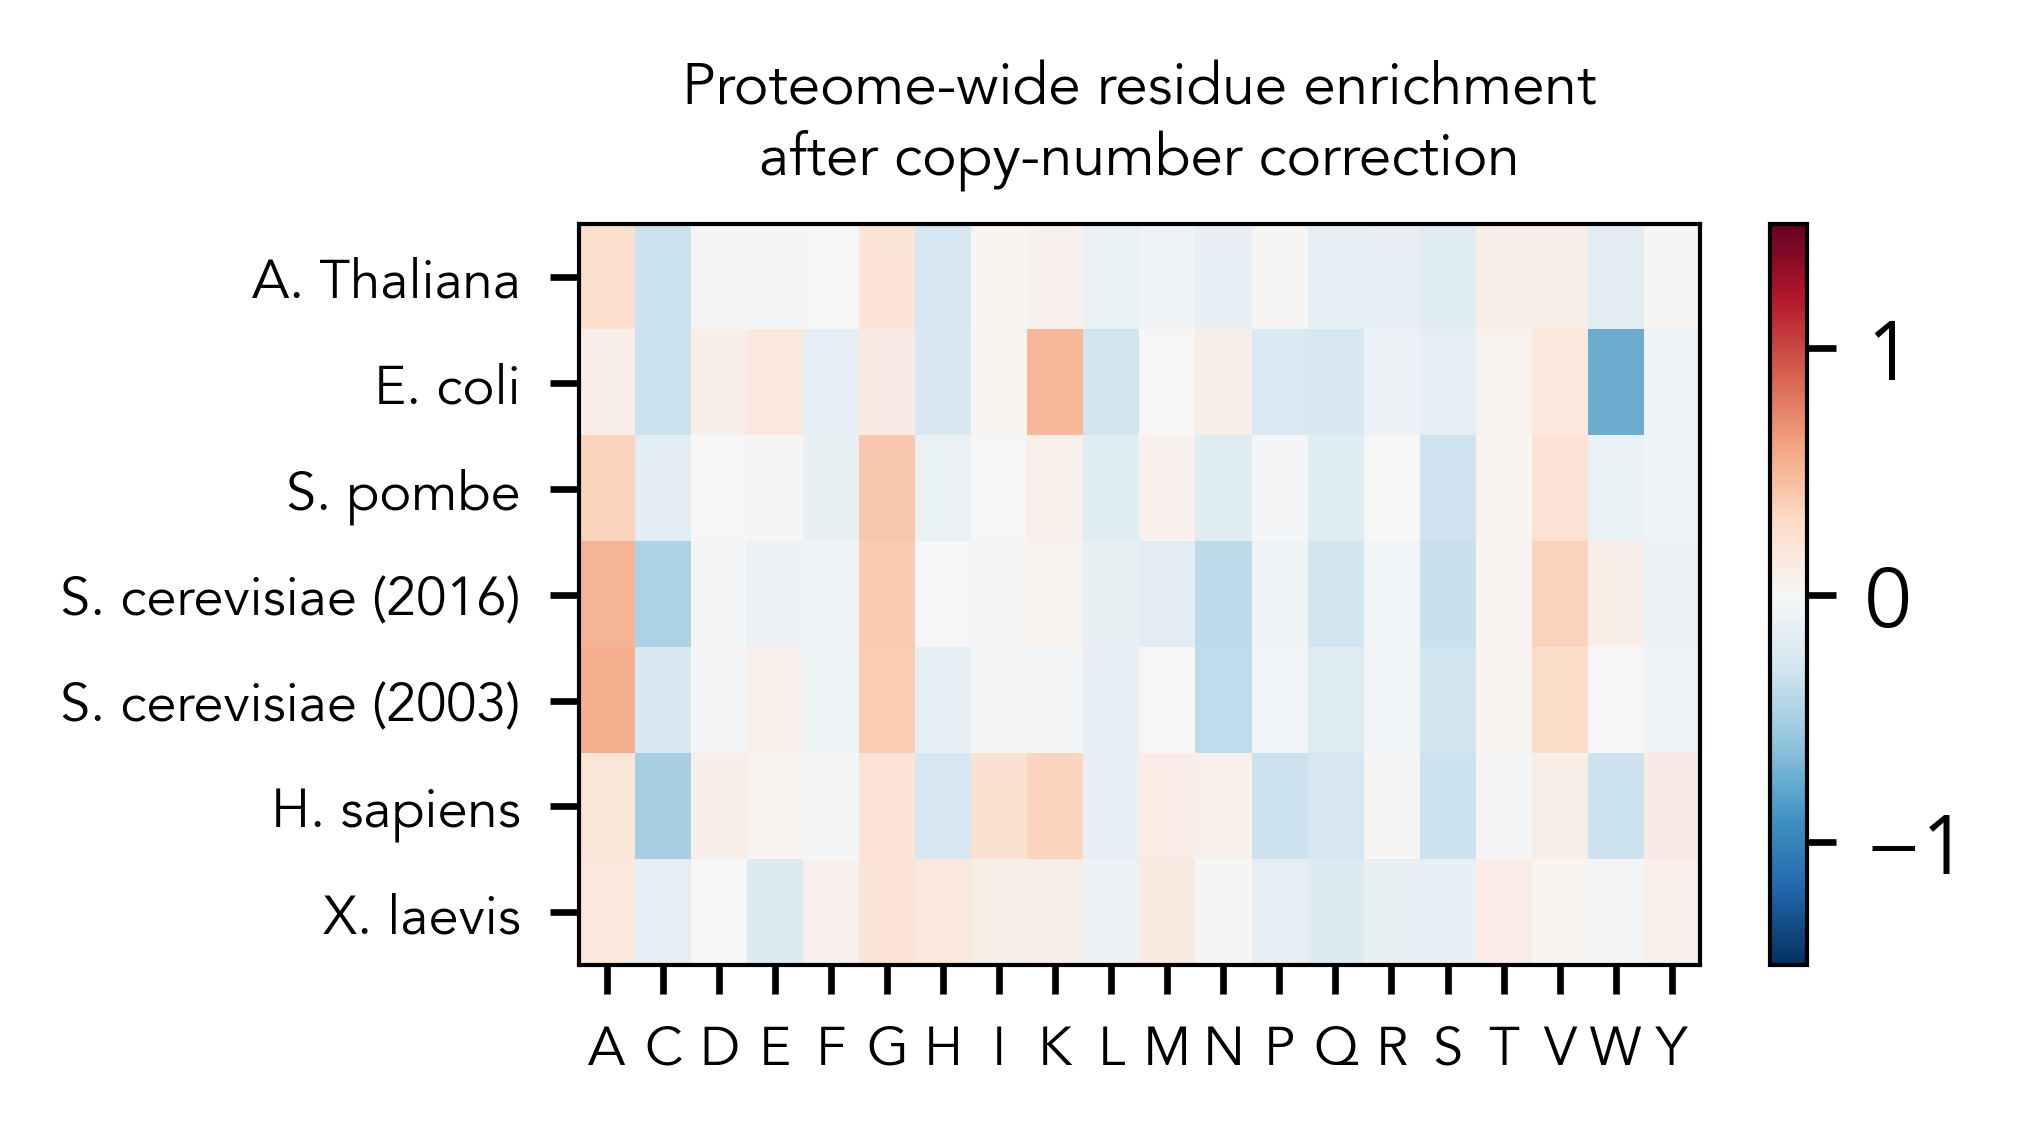

In [23]:
figure(None, (3.5,2.), dpi=300)

plt.imshow(np.log2(np.array(all_aa_counts_cn)/np.array(all_aa_counts_niave)),cmap='RdBu_r', aspect='auto')
plt.colorbar()
plt.clim([-1.5,1.5])
plt.xticks(np.arange(0,20), valid_aa, fontsize=6.5)
plt.yticks(np.arange(0,7), namesnice, fontsize=6.5)
plt.title('Proteome-wide residue enrichment\nafter copy-number correction', fontsize=7)
plt.tight_layout()
print('')

### Same analysis but for disordered regions

In [24]:

idr_aa_counts_niave = []
idr_aa_counts_cn = []

for organism in names:
    proteome = all_proteomes[organism]


    counts = []
    for protein in proteome:
        for domain in protein.domains:
            
            # we do this so we avoid initiatior methione
            # residues skewing the composition bias
            if domain.start == 1:
                
                # discard initiator methonine if N-terminal IDR
                start = 2
            else:
                start = domain.start
            
            local_seq = protein.get_sequence_region(start,domain.end)
            
            counts.append([local_seq.count(i) for i in valid_aa])
        
    idr_aa_counts_niave.append(np.sum(counts,0)/np.sum(counts).tolist())

    counts = []
    for protein in proteome:
        for domain in protein.domains:

            # we do this so we avoid initiatior methione
            # residues skewing the composition bias
            if domain.start == 1:
                
                # discard initiator methonine if N-terminal IDR
                start = 2
            else:
                start = domain.start
            
            local_seq = protein.get_sequence_region(start,domain.end)
            counts.append([local_seq.count(i)*protein.attribute('copy_number') for i in valid_aa])

    idr_aa_counts_cn.append(np.sum(counts,0)/np.sum(counts).tolist())
    
    

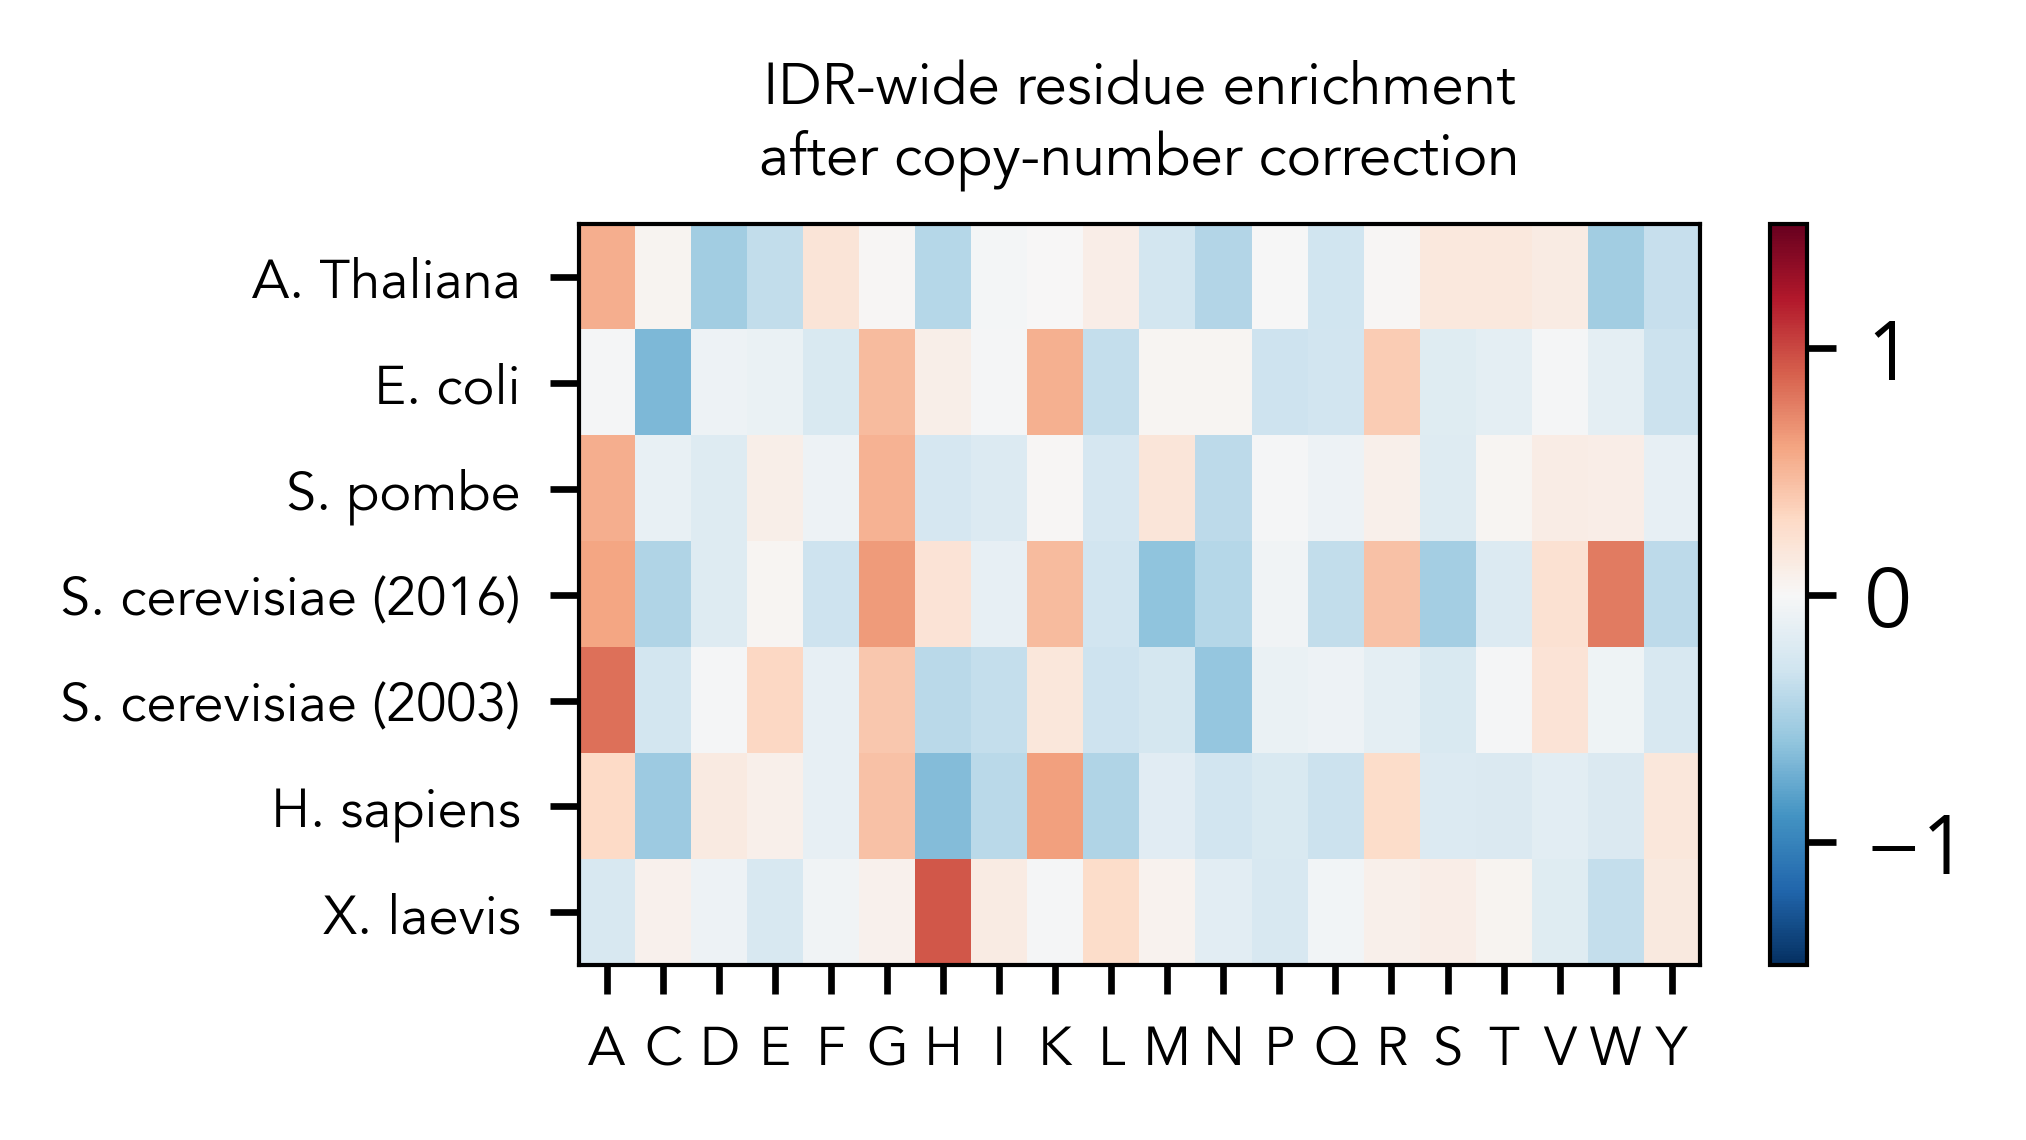

In [25]:
figure(None, (3.5,2.), dpi=300)

plt.imshow(np.log2(np.array(idr_aa_counts_cn)/np.array(idr_aa_counts_niave)),cmap='RdBu_r', aspect='auto')
plt.colorbar()
plt.clim([-1.5,1.5])
plt.xticks(np.arange(0,20), valid_aa, fontsize=6.5)
plt.yticks(np.arange(0,7), namesnice, fontsize=6.5)
plt.title('IDR-wide residue enrichment\nafter copy-number correction', fontsize=7)
plt.tight_layout()
print('')

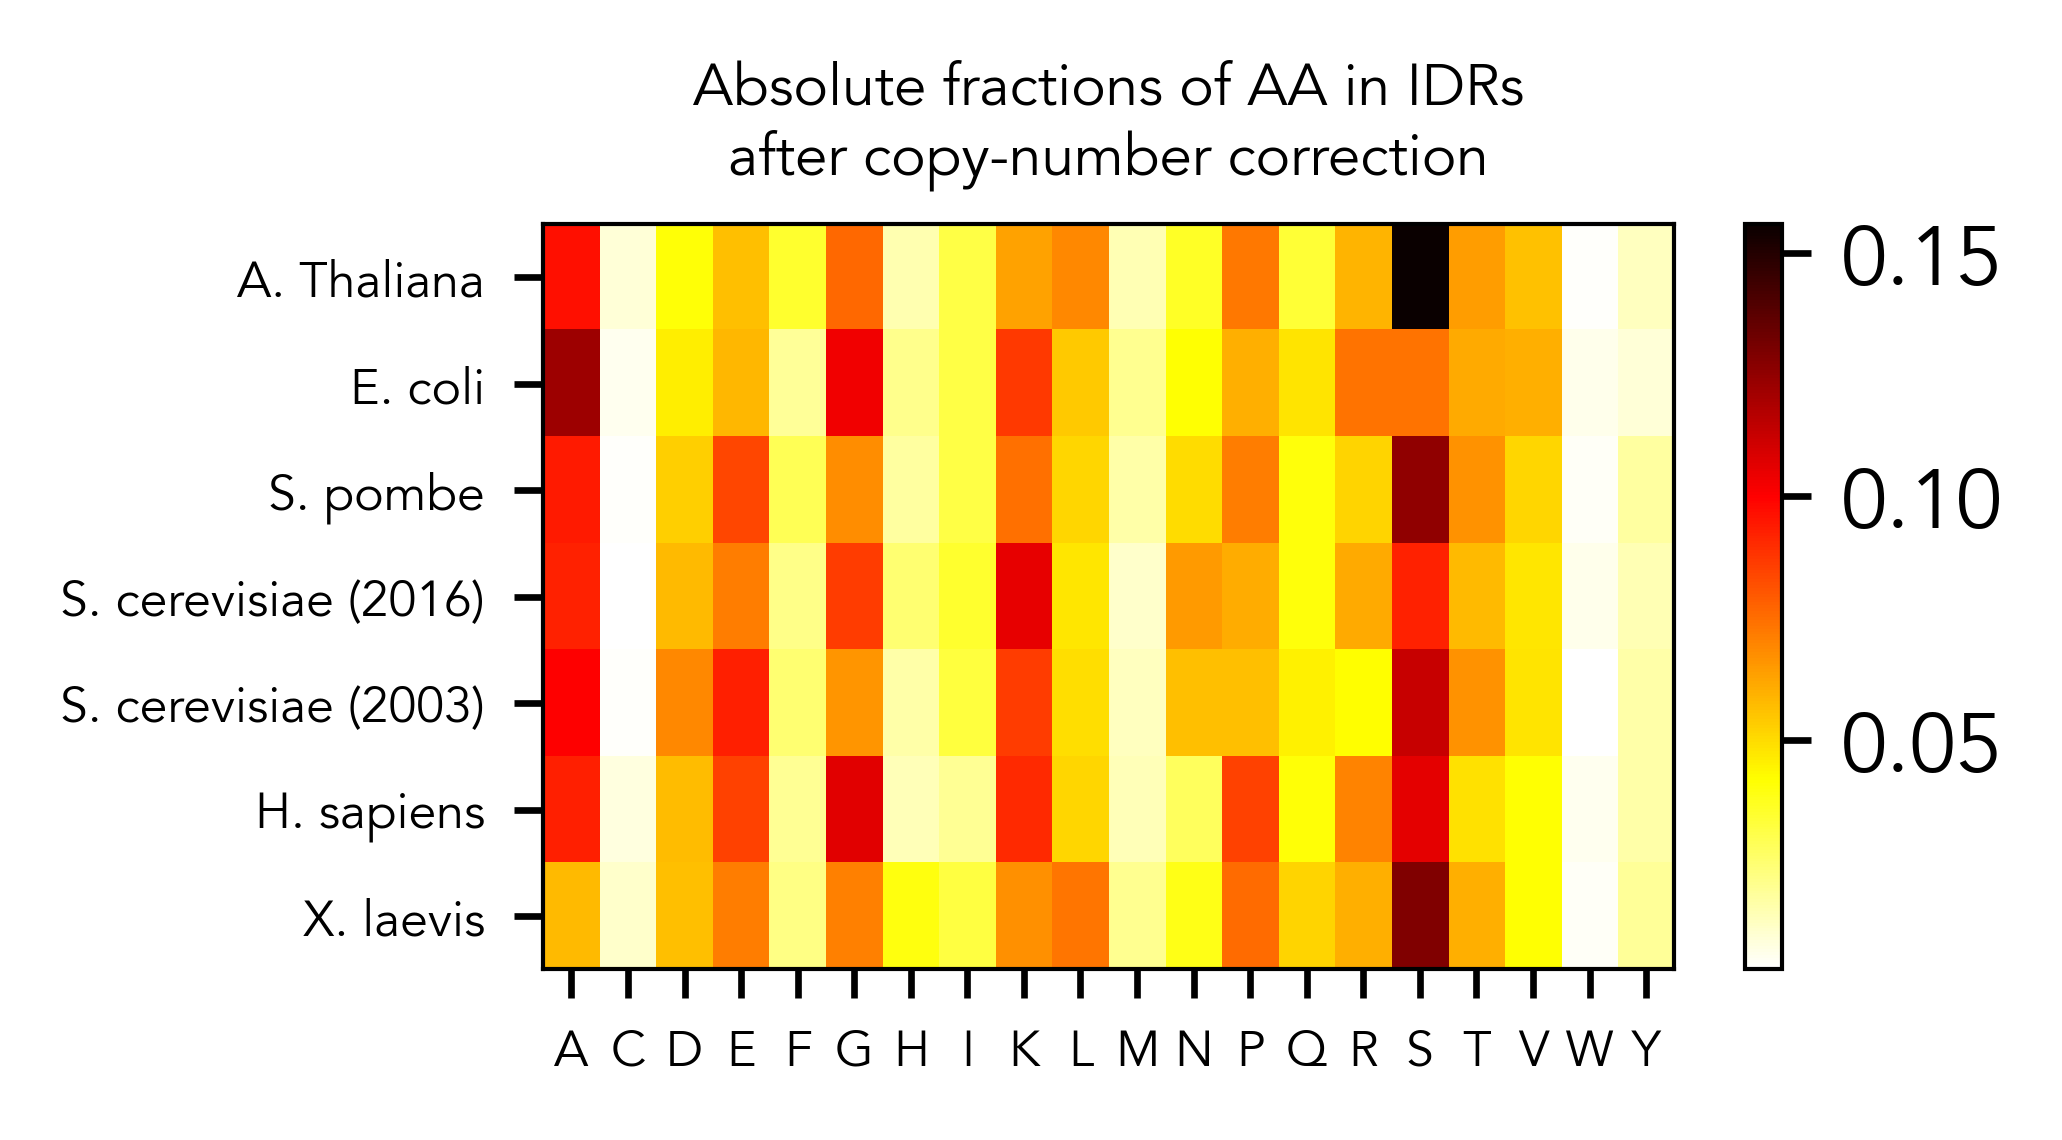

In [26]:
figure(None, (3.5,2.), dpi=300)

plt.imshow(np.array(idr_aa_counts_cn),cmap='hot_r', aspect='auto')
plt.colorbar()
#plt.clim([-1.5,1.5])
plt.xticks(np.arange(0,20), valid_aa, fontsize=6)
plt.yticks(np.arange(0,7), namesnice, fontsize=6)
plt.title('Absolute fractions of AA in IDRs\nafter copy-number correction', fontsize=7)
plt.tight_layout()
print('')

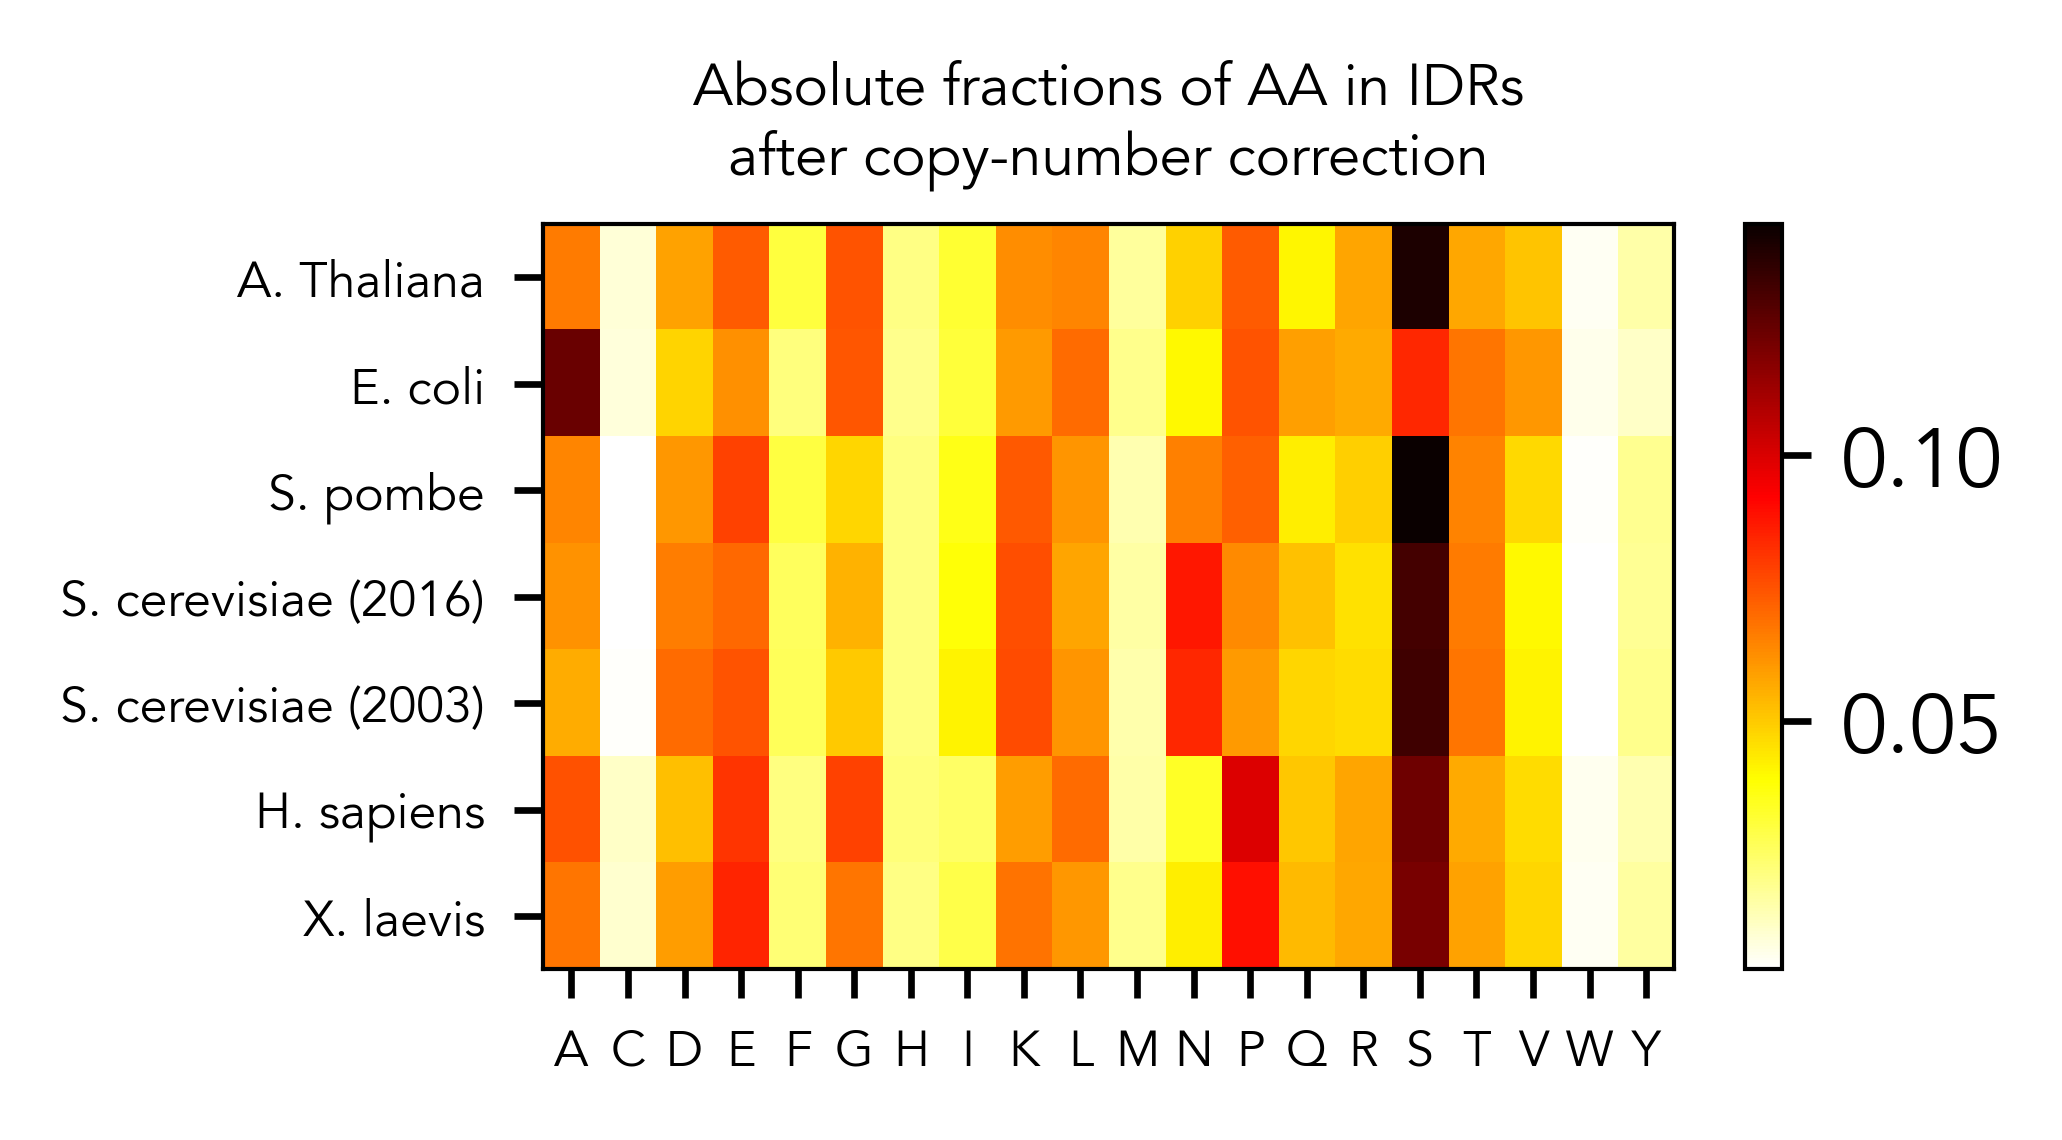

In [27]:
figure(None, (3.5,2.), dpi=300)

plt.imshow(np.array(idr_aa_counts_niave),cmap='hot_r', aspect='auto')
plt.colorbar()
#plt.clim([-1.5,1.5])
plt.xticks(np.arange(0,20), valid_aa,fontsize=6)
plt.yticks(np.arange(0,7), namesnice,fontsize=6)
plt.title('Absolute fractions of AA in IDRs\nafter copy-number correction', fontsize=7)
plt.tight_layout()
print('')

In [28]:
idr_aa_counts_niave[5]

array([0.07544676, 0.01137763, 0.05218499, 0.08111936, 0.02121075,
       0.07828545, 0.02229339, 0.02525593, 0.05921502, 0.06966892,
       0.01564816, 0.03388575, 0.09938831, 0.05091844, 0.05806168,
       0.1219804 , 0.05690729, 0.0463423 , 0.00621154, 0.01459793])

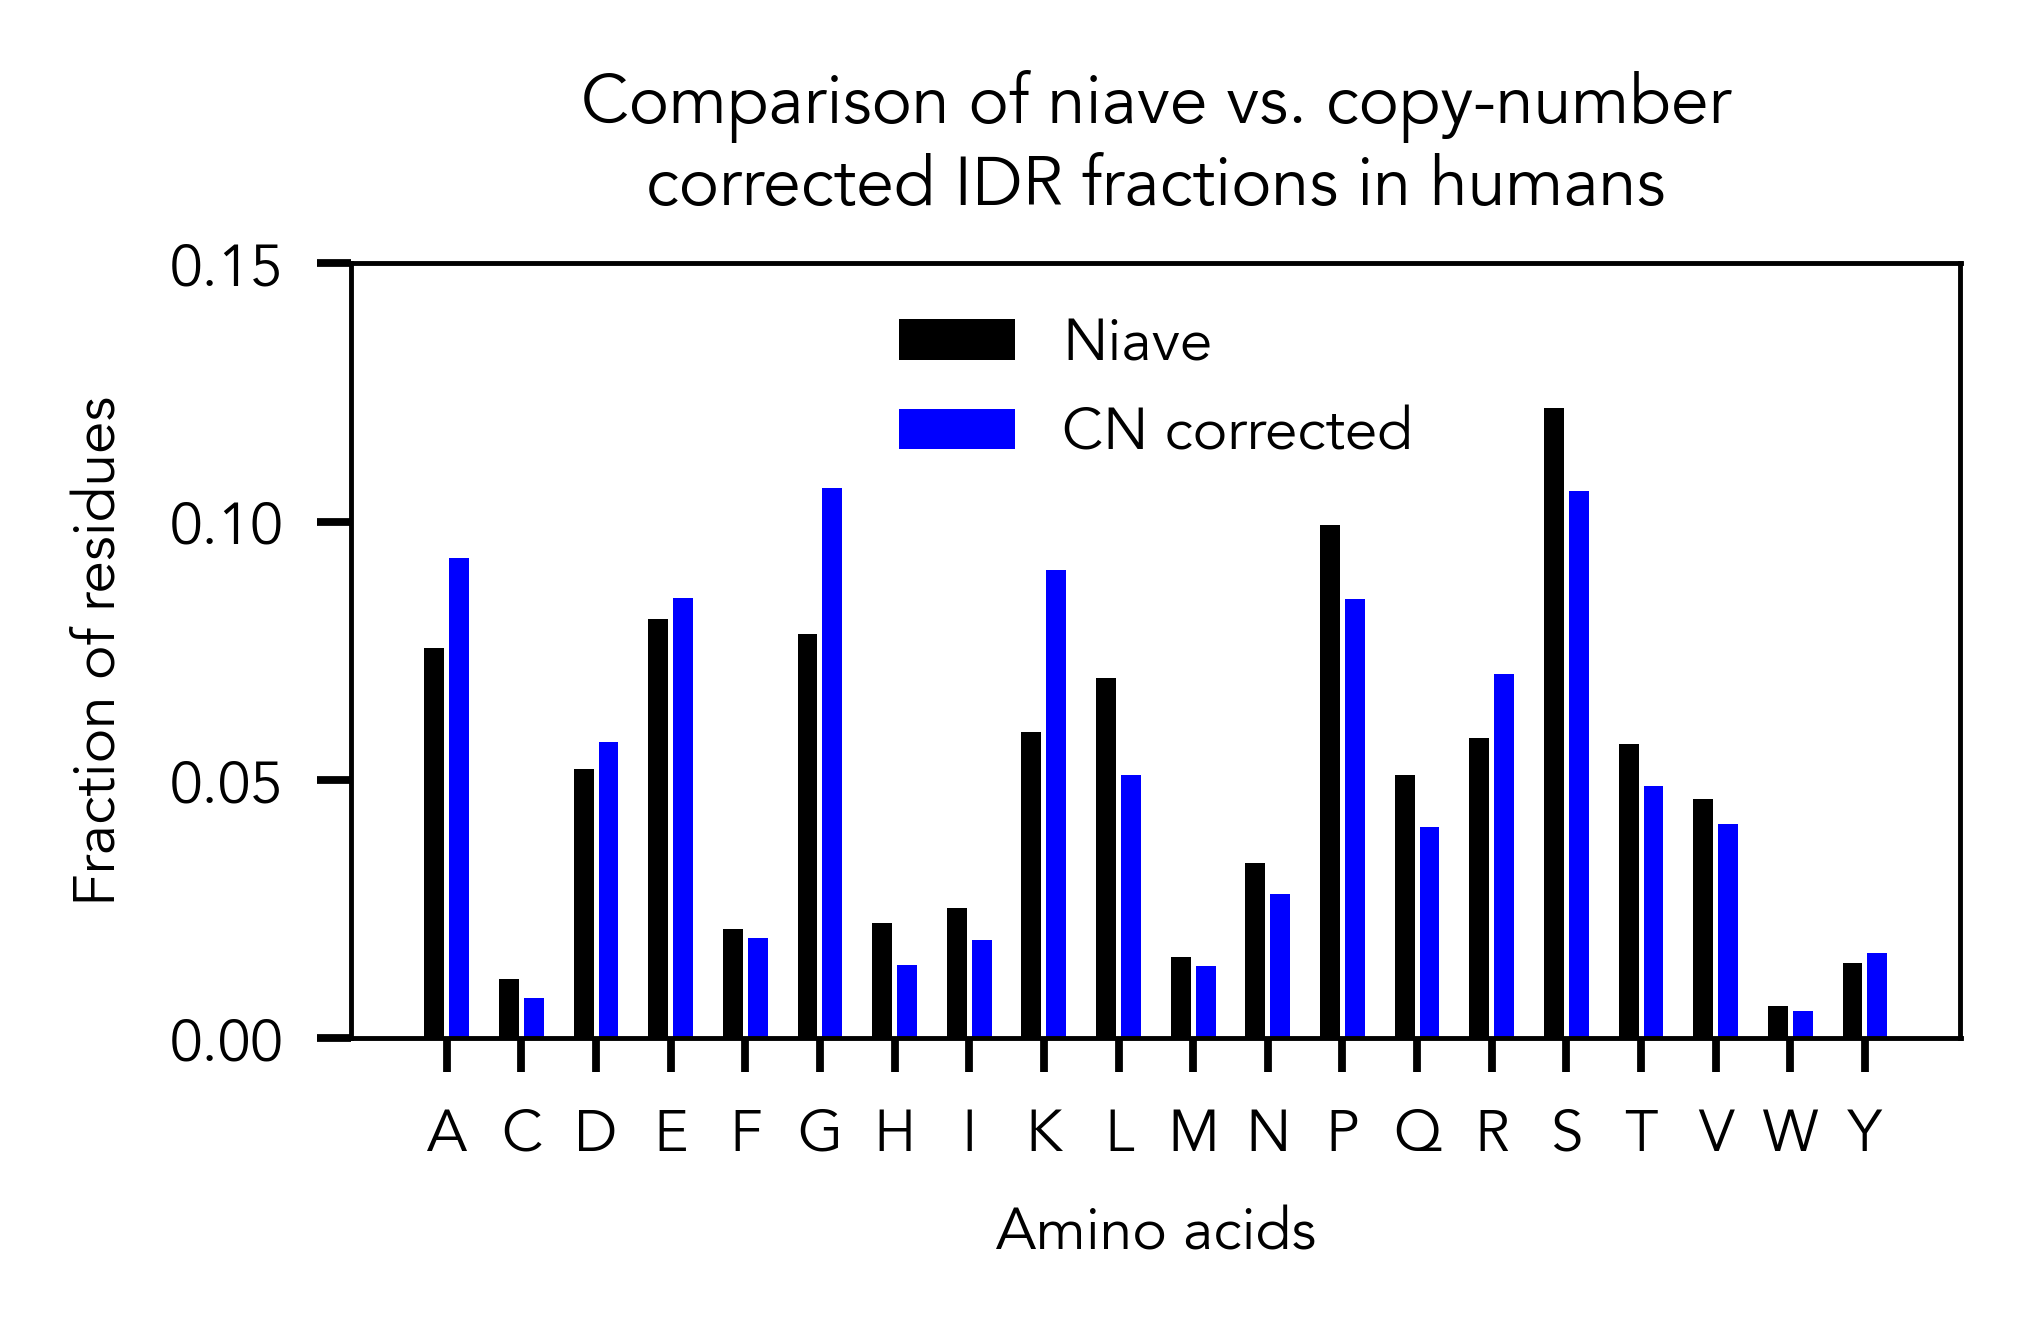

In [29]:
human_idx = names.index('human')
figure(None, (3,2), dpi=350)
stepsize=3
plt.bar(np.arange(1,0+(20*stepsize),stepsize), idr_aa_counts_niave[human_idx],color='k', label='Niave')
plt.bar(np.arange(2,1+(20*stepsize),stepsize), idr_aa_counts_cn[human_idx], color='blue', label='CN corrected')
plt.ylim(0,0.15)
#plt.plot(list(niave_aa_count.values()))
plt.xticks(np.arange(1.5,(20*stepsize)+0.5,stepsize),valid_aa, fontsize=6)
plt.ylabel('Fraction of residues', fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Amino acids', fontsize=6)
plt.legend(frameon=False, fontsize=6)

plt.title('Comparison of niave vs. copy-number\ncorrected IDR fractions in humans', fontsize=7)
plt.tight_layout()
print('')